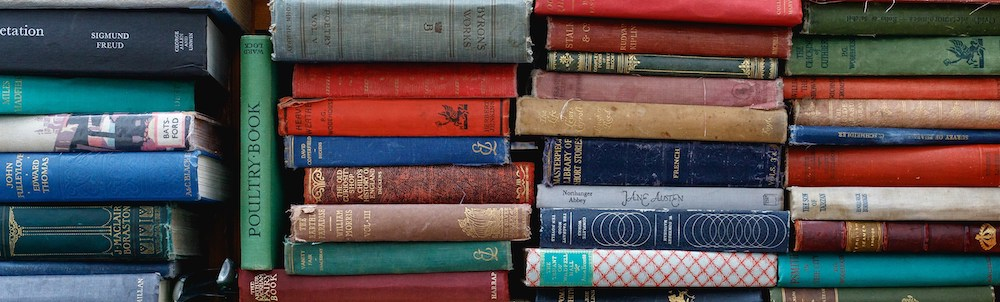


# Introduction

Welcome to Team Bookaholic! We are Mason Liebe, Nami Kim, San Kim, and Wai-Sum Wu. Inspired by our learning from CIS5450 at Penn, we set out to tackle the age old problem of - "what do I read next?" We all love books and have wondered whether this is the best Amazon can do in providing personalized reading recommendations.

So we decided to build a novel book recommender system. Our intention is to develop a robust methodology for predicting which books a user will like given their previous ratings and/or personal information, utilizing the big data and machine learning knowledge we've acculuated over the semester.

We began with a dataset of 278,858 users (with age/location data) providing 149,780 ratings from 1 to 10 of 271,379 distinct books. We built recommender models based on ratings, readers, and books, experiencing a mix of challenges, frustrations, and exhilaration along the way.

Below, you'll find a detailed description of our journey.

Test out our recommender for yourself at
https://cis545-book-project-60m9b4032y8.streamlit.app/Parameter_based_book_recommender

Github repo for the front-end: https://github.com/wuwaisum0517/cis545-book-project



# 1. Dataset

# 1.1 Kaggle Dataset

We begin with a dataset of book ratings from the book review community 'BookCrossing' (available here: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/).

The dataset is comprised of three parts, each containing the following information:
- Books: ISBN (unique identifier number for each book), title, author, year of publication, publisher, cover image URL.
- Users: user ID, location, age.
- Ratings: user ID, ISBN, rating.

Among many book-related datasets, we chose this one because it includes user location and age information, which will allow us to make more personalized recommendations. Additionally, it is in the pulic domain, freely available for anyone to use for any purpose without any restrictions.

**Provenance**

SOURCES

https://www.bookcrossing.com/howto

COLLECTION METHODOLOGY

Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books. I preprocessed and cleaned data format.

License

CC0: Public Domain

(quoted from the data source https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/)

We start with importing Python libraries. In Python programming, libraries are collections of pre-written code that include functions, classes, and variables designed to perform common tasks. They allows us to take advantage of these predefined functions without havign to write everything from scratch, making our development process faster and more efficient.

In [ ]:
# Import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
import joblib

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
# Suppress all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

Now we import Kaggle dataset into the Notebook. To do so, we first mount Google drive, so we can unpack the dataset into the Google drive space where we can access from our notebook.

In [ ]:
%%capture
!apt update
!pip install kaggle

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d arashnic/book-recommendation-dataset

['Downloading book-recommendation-dataset.zip to /content',
 '',
 '  0% 0.00/24.3M [00:00<?, ?B/s]',
 ' 21% 5.00M/24.3M [00:00<00:00, 36.3MB/s]',
 ' 70% 17.0M/24.3M [00:00<00:00, 53.4MB/s]',
 '',
 '100% 24.3M/24.3M [00:00<00:00, 67.7MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/book-recommendation-dataset.zip

Archive:  /content/book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


The Kaggle dataset consists of three CSV files. We read each of them into our Pandas dataframe and check their contents.

In [ ]:
# Read the csv files and save them to dataframes called 'df_users', 'df_users', and 'df_ratings'
df_users = pd.read_csv('/content/Users.csv')
df_books = pd.read_csv('/content/Books.csv')
df_ratings = pd.read_csv('/content/Ratings.csv')

<ipython-input-8-91716d4aba56>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('/content/Books.csv')


In [ ]:
# check contents in 'df_users'
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
# check contents in 'df_books'
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
# check contents in 'df_ratings'
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


### 1.1.1 Data Wrangling and Cleaning

Now we prepare our data for analysis by cleaning it, fixing or removing incorrect, incomplete, or irrelevant data.

To streamline our analysis and make answering certain questions more straightforward, we will focus exclusively on data from the United States. This decision was made due to the comparatively significant volume of user data from the United States.

Let's first review the data by country.

In [ ]:
# Create 'Country' by using 'Location'
# extract location information from the users data
df_users['Country'] = df_users['Location'].apply(lambda x: x.split(',')[-1].strip())
# set up a new df_country with user ID and country information
df_country = df_users[['User-ID', 'Country']]
df_country.rename(columns={'User-ID': 'Count'}, inplace=True)
# group by country, show number of users in each country
df_country = df_country.groupby(by='Country', as_index=False).count()
df_country.sort_values(by='Count', ascending=False, inplace=True)
df_country

Country   Count
662                                  usa  139711
115                               canada   21658
646                       united kingdom   18538
241                              germany   17043
565                                spain   13147
..                                   ...     ...
372                           madagascar       1
371                           macedonia"       1
101                          burkinafasu       1
366  los estados unidos de norte america       1
442                          nyhamnsläge       1

[709 rows x 2 columns]

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_country.to_csv('df_country.csv',index = True)

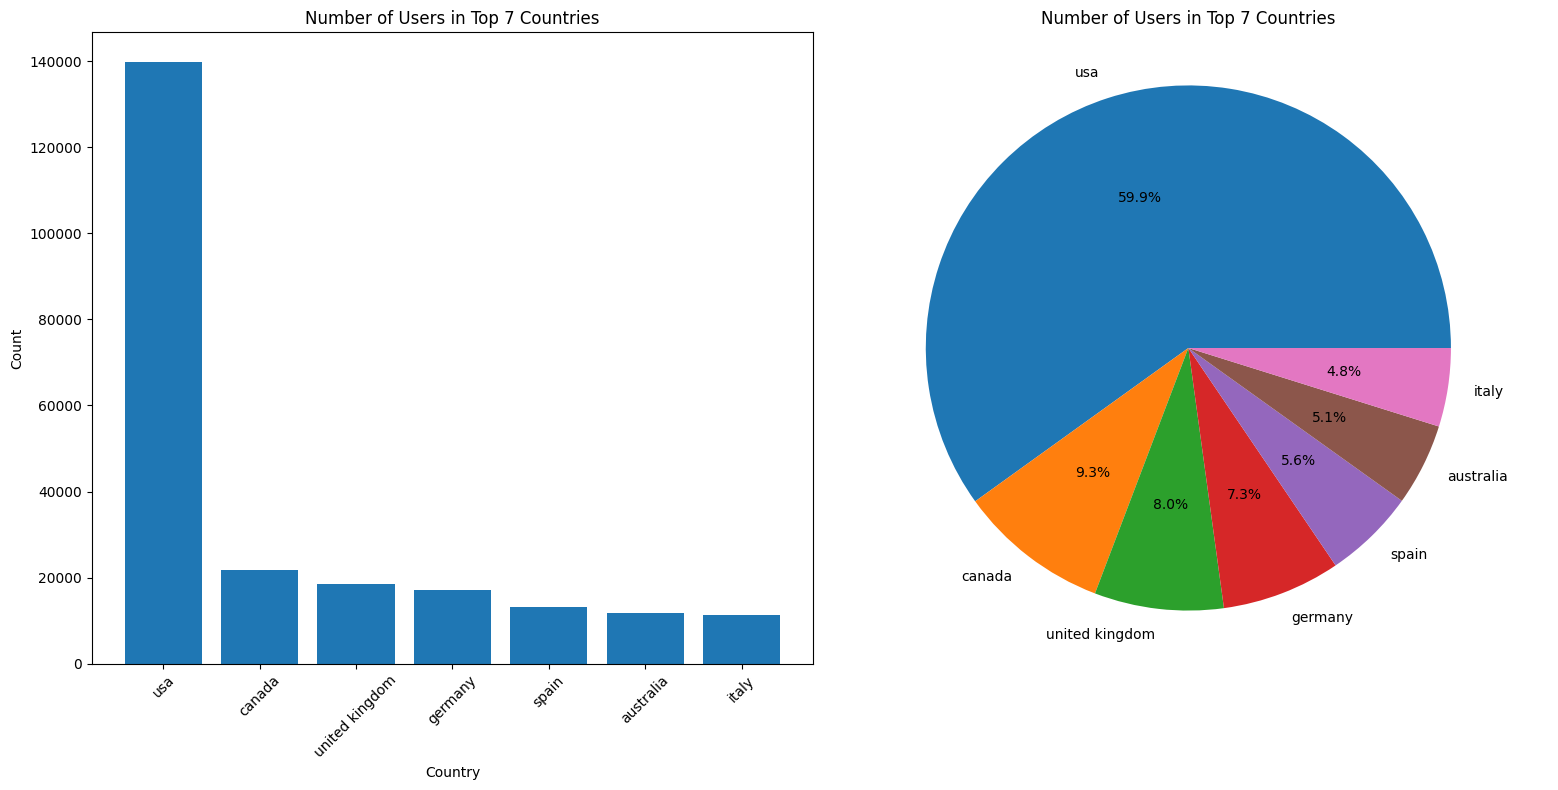

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart
ax[0].bar(df_country['Country'][:7], df_country['Count'][:7])
ax[0].set_title('Number of Users in Top 7 Countries')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(df_country['Country'], rotation=45)

# Pie chart
ax[1].pie(df_country['Count'][:7], labels=df_country['Country'][:7], autopct='%.1f%%')
ax[1].set_title('Number of Users in Top 7 Countries')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.tight_layout()
plt.show()

We separate only the data for US users and clean up their locations into city and state.

In [ ]:
# Focus only on USA
df_users_usa = df_users[df_users['Country'] == 'usa']

# Create 'City' and 'State' by using 'Location'
df_users_usa['City'] = df_users_usa['Location'].apply(lambda x: x.split(',')[0].strip())
df_users_usa['State'] = df_users_usa['Location'].apply(lambda x: x.split(',')[-2].strip())

df_users_usa = df_users_usa[['User-ID', 'Age', 'Location', 'City', 'State', 'Country']]

Now that we have only the US users' data, we will merge the three datasets (users, books, ratings) into one combined DataFrame. This will allow us to see each user, their rating of the book, and information about that book.

In [ ]:
# Merge the dataframes as 'df_combined'
df_books_usa = df_books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S']]
df_books_usa.rename(columns={'Image-URL-S': 'Image-URL'}, inplace=True)

df_combined = df_users_usa.merge(df_ratings, how='inner', on='User-ID').merge(df_books_usa, how='inner', on='ISBN')
df_combined.dropna(inplace=True)
df_combined.head()

User-ID   Age                   Location       City       State Country  \
0        2  18.0  stockton, california, usa   stockton  california     usa   
3      388  35.0  nashville, tennessee, usa  nashville   tennessee     usa   
4     2977  25.0  richland, washington, usa   richland  washington     usa   
6     3363  29.0  knoxville, tennessee, usa  knoxville   tennessee     usa   
7     6795  31.0      portland, oregon, usa   portland      oregon     usa   

         ISBN  Book-Rating           Book-Title         Book-Author  \
0  0195153448            0  Classical Mythology  Mark P. O. Morford   
3  0440234743            0        The Testament        John Grisham   
4  0440234743            0        The Testament        John Grisham   
6  0440234743            0        The Testament        John Grisham   
7  0440234743            0        The Testament        John Grisham   

  Year-Of-Publication                Publisher  \
0                2002  Oxford University Press   
3                1999                     Dell   
4                1999                     Dell   
6                1999                     Dell   
7                1999                     Dell   

                                           Image-URL  
0  http://images.amazon.com/images/P/0195153448.0...  
3  http://images.amazon.com/images/P/0440234743.0...  
4  http://images.amazon.com/images/P/0440234743.0...  
6  http://images.amazon.com/images/P/0440234743.0...  
7  http://images.amazon.com/images/P/0440234743.0...

Text information, such as names, needs to be further cleaned. Here, we pay particular attention to cleaning the city and state names, as we will use this information later as a basis for recommendations.

In [ ]:
# Cleaning in 'State'
df_combined['State'] = df_combined['State'].apply(lambda x: x.replace('.', ''))
df_combined['State'] = df_combined['State'].apply(lambda x: re.sub('[\[0-9\]]', '', x))

typo_to_abbr = {
    'n carolina': 'nc',
    'washington state': 'wa',
    'wva': 'wv',
    'michigan/new jersey': 'nj',
    'massachusattes': 'ma',
    'austin': 'tx',
    'georga': 'ga',
    'new  york': 'ny',
    'northern marianas provinces': 'mp',
    'united states virgin islands': 'vi'
}
df_combined['State'] = df_combined['State'].apply(lambda x: typo_to_abbr[x] if x in typo_to_abbr.keys() else x)
df_combined['State'].unique()

array(['california', 'tennessee', 'washington', 'oregon', 'texas',
       'colorado', 'kentucky', 'maryland', 'alabama', 'new jersey',
       'north carolina', 'missouri', 'virginia', 'pennsylvania',
       'indiana', 'louisiana', 'ohio', 'florida', 'minnesota', 'michigan',
       'west virginia', 'wisconsin', 'new hampshire', 'illinois',
       'new york', 'arkansas', 'nevada', 'oklahoma', 'rhode island',
       'hawaii', 'alaska', 'georgia', 'maine', 'arizona', 'north dakota',
       'idaho', 'connecticut', 'massachusetts', 'mississippi', 'utah',
       'nebraska', 'iowa', 'ap', 'montana', 'kansas', 'delaware',
       'new mexico', 'south carolina', 'ae', 'dc', '', 'wyoming', 'nm',
       'south dakota', 'ca', 'vermont', 'nc', 'n/a', 'tx',
       'armed services europe', 'wa', 'puerto rico', 'nj',
       'western pennsylvania', 'ak', 'ga', 'campania', 'rheinland-pfalz',
       'yedor', 'wv', 'moving', 'pella', 'ma', 'england',
       'my own little world', 'co', 'tn', 'pa', 'ar',
   

In [ ]:
# Cleaning in 'State'
abbr_to_state = {
    'ak': 'alaska',
    'al': 'alabama',
    'ar': 'arkansas',
    'az': 'arizona',
    'ca': 'california',
    'co': 'colorado',
    'ct': 'connecticut',
    'de': 'delaware',
    'fl': 'florida',
    'ga': 'georgia',
    'hi': 'hawaii',
    'ia': 'iowa',
    'id': 'idaho',
    'il': 'illinois',
    'in': 'indiana',
    'ks': 'kansas',
    'ky': 'kentucky',
    'la': 'louisiana',
    'ma': 'massachusetts',
    'md': 'maryland',
    'me': 'maine',
    'mi': 'michigan',
    'mn': 'minnesota',
    'mo': 'missouri',
    'ms': 'mississippi',
    'mt': 'montana',
    'nc': 'north carolina',
    'nd': 'north dakota',
    'ne': 'nebraska',
    'nh': 'new hampshire',
    'nj': 'new jersey',
    'nm': 'new mexico',
    'nv': 'nevada',
    'ny': 'new york',
    'oh': 'ohio',
    'ok': 'oklahoma',
    'or': 'oregon',
    'pa': 'pennsylvania',
    'ri': 'rhode island',
    'sc': 'south carolina',
    'sd': 'south dakota',
    'tn': 'tennessee',
    'tx': 'texas',
    'ut': 'utah',
    'va': 'virginia',
    'vt': 'vermont',
    'wa': 'washington',
    'wi': 'wisconsin',
    'wv': 'west virginia',
    'wy': 'wyoming',
    'dc': 'district of columbia',
    'as': 'american samoa',
    'gu': 'guam',
    'mp': 'northern mariana islands',
    'pr': 'puerto rico pr',
    'vi': 'virgin islands'
}
df_combined['State'] = df_combined['State'].apply(lambda x: abbr_to_state[x] if x in abbr_to_state.keys() else x)
df_combined = df_combined[df_combined['State'].isin(abbr_to_state.values())]
df_combined['State'].unique()

array(['california', 'tennessee', 'washington', 'oregon', 'texas',
       'colorado', 'kentucky', 'maryland', 'alabama', 'new jersey',
       'north carolina', 'missouri', 'virginia', 'pennsylvania',
       'indiana', 'louisiana', 'ohio', 'florida', 'minnesota', 'michigan',
       'west virginia', 'wisconsin', 'new hampshire', 'illinois',
       'new york', 'arkansas', 'nevada', 'oklahoma', 'rhode island',
       'hawaii', 'alaska', 'georgia', 'maine', 'arizona', 'north dakota',
       'idaho', 'connecticut', 'massachusetts', 'mississippi', 'utah',
       'nebraska', 'iowa', 'montana', 'kansas', 'delaware', 'new mexico',
       'south carolina', 'district of columbia', 'wyoming',
       'south dakota', 'vermont', 'virgin islands',
       'northern mariana islands', 'guam'], dtype=object)

In [ ]:
# Cleaning in 'City'
df_combined = df_combined[~df_combined['City'].apply(lambda x: x.startswith('...') or x.startswith('~') or x.startswith('__') or x.startswith('--'))]
df_combined['City'] = df_combined['City'].apply(lambda x: x.split('/')[0].strip() if '/' in x else x)
df_combined['City'] = df_combined['City'].apply(lambda x: x.split('(')[0].strip() if '(' in x else x)
df_combined['City'] = df_combined['City'].apply(lambda x: x.replace('  ', ' '))
df_combined['City'] = df_combined['City'].apply(lambda x: re.sub('[\[0-9\]]', '', x).strip())
df_combined['City'].unique()

array(['stockton', 'nashville', 'richland', ..., 'palm beach',
       'lower burrell', 'lousiville'], dtype=object)

In [ ]:
# Cleaning in 'City'
typo_to_city = {
    'west new york      nj': 'west new york',
    'new york ny': 'new york',
    'st louis': 'st. louis',
    'fort stewart': 'ft. stewart'
}
df_combined['City'] = df_combined['City'].apply(lambda x: typo_to_city[x] if x in typo_to_city.keys() else x)
df_combined['City'].unique()

array(['stockton', 'nashville', 'richland', ..., 'palm beach',
       'lower burrell', 'lousiville'], dtype=object)

In [ ]:
# Cleaning in 'Book-Author'
df_combined['Book-Author'] = df_combined['Book-Author'].apply(lambda x: x.replace('&amp;', '&'))
df_combined['Book-Author'] = df_combined['Book-Author'].apply(lambda x: x.replace('Not Applicable (Na )', 'No Authors'))
df_combined['Book-Author'] = df_combined['Book-Author'].apply(lambda x: x.title())

# Cleaning in 'Book-Title'
df_combined['Book-Title'] = df_combined['Book-Title'].apply(lambda x: x.replace('&amp;', '&'))
df_combined['Book-Title'] = df_combined['Book-Title'].apply(lambda x: x.replace(' :', ':'))

# Cleaning in 'Publisher'
df_combined['Publisher'] = df_combined['Publisher'].apply(lambda x: x.replace('&amp;', '&'))

# Cleaning in 'Book-Author'
typo_to_author = {
    'J.K. Rowling': 'J. K. Rowling',
    'Joanne K. Rowling': 'J. K. Rowling',
    'J .K. Rowling': 'J. K. Rowling'
}
df_combined['Book-Author'] = df_combined['Book-Author'].apply(lambda x: typo_to_author[x] if x in typo_to_author.keys() else x)

# Convert publication year from string to int, setting errors='coerce' will convert non-convertible values to NaN
df_combined['Year-Of-Publication'] = pd.to_numeric(df_combined['Year-Of-Publication'], errors='coerce')

Check numeric data and remove outliers.

In [ ]:
df_combined.describe()

User-ID            Age    Book-Rating  Year-Of-Publication
count  550290.000000  550290.000000  550290.000000        550290.000000
mean   140967.311790      38.358338       2.611032          1983.202895
std     78869.411317      14.140326       3.828709           155.125980
min         2.000000       0.000000       0.000000             0.000000
25%     73394.000000      29.000000       0.000000          1992.000000
50%    141665.000000      36.000000       0.000000          1997.000000
75%    209625.000000      46.000000       7.000000          2001.000000
max    278851.000000     237.000000      10.000000          2050.000000

In [ ]:
# clip age outlier over 95
df_combined['Age'] = df_combined['Age'].clip(upper=95)

# Data is collected in 2004, so any publication date after 2004 must be an error. Remove them
df_combined['Year-Of-Publication'] = df_combined['Year-Of-Publication'].clip(upper=2004)

In [ ]:
# count number of zeros in variables
count_zero_year = (df_combined['Year-Of-Publication'] == 0).sum()
print(f"Count of '0' as publication year: {count_zero_year}")

count_zero_age = (df_combined['Age'] == 0).sum()
print(f"Count of '0' as age: {count_zero_age}")

Count of '0' as publication year: 3339
Count of '0' as age: 223


In [ ]:
# Replace zero with NaN in the publication year, age
df_combined['Year-Of-Publication'] = df_combined['Year-Of-Publication'].replace(0, np.nan)
df_combined['Age'] = df_combined['Age'].replace(0, np.nan)

# Drop rows where either age or Year-Of-Publication column has a null value
df_combined = df_combined.dropna(subset=['Age', 'Year-Of-Publication'])

# Counting nulls in each column
null_counts = df_combined.isnull().sum()

# print the number of nulls per column
print("Number of nulls in each column:")
print(null_counts)

Number of nulls in each column:
User-ID                0
Age                    0
Location               0
City                   0
State                  0
Country                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL              0
dtype: int64


Here is our final cleaned dataset.

In [ ]:
df_cleaned = df_combined.copy()
df_cleaned.head()

User-ID   Age                   Location       City       State Country  \
0        2  18.0  stockton, california, usa   stockton  california     usa   
3      388  35.0  nashville, tennessee, usa  nashville   tennessee     usa   
4     2977  25.0  richland, washington, usa   richland  washington     usa   
6     3363  29.0  knoxville, tennessee, usa  knoxville   tennessee     usa   
7     6795  31.0      portland, oregon, usa   portland      oregon     usa   

         ISBN  Book-Rating           Book-Title         Book-Author  \
0  0195153448            0  Classical Mythology  Mark P. O. Morford   
3  0440234743            0        The Testament        John Grisham   
4  0440234743            0        The Testament        John Grisham   
6  0440234743            0        The Testament        John Grisham   
7  0440234743            0        The Testament        John Grisham   

   Year-Of-Publication                Publisher  \
0               2002.0  Oxford University Press   
3               1999.0                     Dell   
4               1999.0                     Dell   
6               1999.0                     Dell   
7               1999.0                     Dell   

                                           Image-URL  
0  http://images.amazon.com/images/P/0195153448.0...  
3  http://images.amazon.com/images/P/0440234743.0...  
4  http://images.amazon.com/images/P/0440234743.0...  
6  http://images.amazon.com/images/P/0440234743.0...  
7  http://images.amazon.com/images/P/0440234743.0...

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546732 entries, 0 to 746465
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              546732 non-null  int64  
 1   Age                  546732 non-null  float64
 2   Location             546732 non-null  object 
 3   City                 546732 non-null  object 
 4   State                546732 non-null  object 
 5   Country              546732 non-null  object 
 6   ISBN                 546732 non-null  object 
 7   Book-Rating          546732 non-null  int64  
 8   Book-Title           546732 non-null  object 
 9   Book-Author          546732 non-null  object 
 10  Year-Of-Publication  546732 non-null  float64
 11  Publisher            546732 non-null  object 
 12  Image-URL            546732 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 58.4+ MB


# 1.2 Additional Web Data

The enhance our model, we have decided to collect additional data. We chose the Library of Congress (LoC) as our source because it is a reliable and reputable repository of book-related information and offers APIs.

Library of Congree APIs https://www.loc.gov/apis/

We considered other sources such as Amazon Books and Google Books, but they were not viable because of registration hurdles and fees. We refrain from scraping Amazon directly as it violates their terms of use.

**LoC Data Acquisition**

We connect to the Library of Congress (LoC) API. By providing the ISBN, a unique identifier for each book, we can obtain relevant information that the library offers. Among these, we save the title, subjects, page length, location related to the book, and summary of the book. If any of the requested fields are empty, we replace them with `None`.

**Working with Rate Limits**

The API is accessible to the public with no API key or authentication required but there are rate limits.

* Burst Limit 20 requests per 10 seconds, Block for 5 minutes
* Crawl Limit	80 requests per 1 minute, Block for 1 hour



In [ ]:
import requests
import time

In [ ]:
def call_loc_api(isbn):
  '''
  @param isbn: unique identifier of a book
  returns: tuple of (title, subjects, publication date,
           medium (includes page lengths), location related to the book, summary)
  '''

  # establish API connection
  api_url = f'https://www.loc.gov/books/?all=True&fo=json&q={isbn}&st=list'
  response = requests.get(api_url)

  # if connection is valid
  if response.status_code == 200:
    data = response.json()

    # items we want to find
    fields = ['title','subjects','medium','location','summary']

    # empty list to store the results
    result = []

    # iterate, look for the wanted items, add to the results list
    for field in fields:
      try:
        result.append(data['results'][0]['item'][field])
      except Exception: # if not found, append None
        result.append(None)

    # Sleep for 1 second to prevent going over the rate limit
    time.sleep(1)
    return tuple(result)

  else: # connection not valid
    return None, None, None, None, None


In [ ]:
# Test run - confrims that our function is working as expected
call_loc_api(9781250012579)

('Eleanor & Park',
 ['Love--Fiction',
  'Dating--Fiction',
  'High schools--Fiction',
  'Schools--Fiction',
  'Omaha (Neb.)--History--20th century--Fiction',
  'JUVENILE FICTION / Love & Romance'],
 ['328 pages ; 22 cm'],
 ['Omaha (Neb.)'],
 ['"Set over the course of one school year in 1986, this is the story of two star-crossed misfits--smart enough to know that first love almost never lasts, but brave and desperate enough to try"-- Provided by publisher.'])

In [ ]:
# get unique ISBN in the dataset
isbn_list = df_cleaned['ISBN'].tolist()
unique_isbn = list(set(isbn_list))
print(f'Number of ISBN in dataset: {len(isbn_list)}')
print(f'Number of unique ISBN in dataset: {len(unique_isbn)}')

# turn ISBN list into a DataFrame
loc_df = pd.DataFrame(unique_isbn, columns =['isbn'])

Number of ISBN in dataset: 546732
Number of unique ISBN in dataset: 169074


Due to the API rate limit, retrieving all information takes more than 45 hours. To proceed, uncomment the cell below and run.

Otherwise, accompanying loc_df.csv file contains the results.

In [ ]:
# %%time
# loc_df[['title','subjects','pages','location','summary']] = loc_df['isbn'].apply(lambda isbn: pd.Series(call_loc_api(isbn)))

In [ ]:
# read the LoC API results from csv file
loc_df = pd.read_csv('loc_df.csv')
loc_df

isbn                              title  \
0      0891072667                        Dream thief   
1      0452011671                                NaN   
2      0373257619                                NaN   
3      0679749535                                NaN   
4      1551667495                                NaN   
...           ...                                ...   
84555  0816763216  What's up with the new principal?   
84556  0745926290                 At home in Mitford   
84557  0345382706               The Alpine Christmas   
84558  0425110451                Wings of the falcon   
84559  0345459210                                NaN   

                                                subjects  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
84555  ['School principals--Fiction', 'Schools--Ficti...   
84556  ['Mitford (N.C. : Imaginary place)--Fiction', ...   
84557  ['Lord, Emma (Fictitious character)--Fiction',...   
84558                                                NaN   
84559                                                NaN   

                            pages            location  \
0             ['409 p. ; 22 cm.']                 NaN   
1                             NaN                 NaN   
2                             NaN                 NaN   
3                             NaN                 NaN   
4                             NaN                 NaN   
...                           ...                 ...   
84555         ['127 p. ; 20 cm.']                 NaN   
84556  ['446 p. : ill. ; 22 cm.']  ['North Carolina']   
84557         ['266 p. ; 18 cm.']   ['Cascade Range']   
84558         ['230 p. ; 17 cm.']                 NaN   
84559                         NaN                 NaN   

                                                 summary  
0                                                    NaN  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4                                                    NaN  
...                                                  ...  
84555                                                NaN  
84556                                                NaN  
84557  ['The discovery of the dismembered bodies of t...  
84558                                                NaN  
84559                                                NaN  

[84560 rows x 6 columns]

## 1.2.1 Data Cleaning
Clean the data to ensure clarity and prepare it for future use.

In [ ]:
# Data Cleaning

# get list of all columns but the 'isbn'
all_columns_but_isbn = loc_df.columns.drop('isbn')

# drop rows where all columns except isbn are None
loc_clean = loc_df.dropna(how='all', subset=all_columns_but_isbn)

# Regex to remove non alphabet chars, turn to lower case, store in list
def clean_val_to_list(s):
  val_list = re.findall(r'\b\w+\b', s)
  lowercase = [word.lower() for word in val_list]

  unique = set(lowercase)
  unique.discard('fiction')

  return  list(unique)

# store the subjects in lists
loc_clean['subjects'] = loc_clean['subjects'].apply(lambda x: clean_val_to_list(x) if not pd.isnull(x) else x)

# remove non-word characters in location
loc_clean['location'] = loc_clean['location'].apply(lambda x: re.sub(r'[^\w\s]', '', x) if not pd.isnull(x) else x)

# regex to find numbers followed by 'pages' or 'p'
def get_page_nums(x):
  match = re.search(r'\b\d+(?=\s*(?:pages|p)\b)', x)
  if match:
      pages = int(match.group(0))
      return pages
  else:
      return None

# clean pages
loc_clean['pages'] = loc_clean['pages'].apply(lambda x: get_page_nums(x) if not pd.isnull(x) else x)

# clean summary - many summaries have the wording 'Provided by publisher'
# this is uneccessary for our analysis so remove them
# also remove any non-word characters

def clean_summary(text):
  # remove Provided by publisher
  cleaned = re.sub(r'Provided by publisher', '', text)
  # remove non-word chars
  cleaned = re.sub(r'[^\w\s]', '', cleaned)
  return cleaned

loc_clean['summary'] = loc_clean['summary'].apply(lambda x: clean_summary(x) if not pd.isnull(x) else x)
loc_clean.reset_index(drop=True, inplace=True)

In [ ]:
# here is the final cleaned data obtained from the Library of Congress.
loc_clean

isbn                                         title  \
0      0891072667                                   Dream thief   
1      0671527126  50 simple ways to make life safer from crime   
2      0897212215                   Successful flower gardening   
3      0385123671                   The ants who took away time   
4      0590436457                               Karen's in love   
...           ...                                           ...   
46168  0849943434                                A perfect love   
46169  0816763216             What's up with the new principal?   
46170  0745926290                            At home in Mitford   
46171  0345382706                          The Alpine Christmas   
46172  0425110451                           Wings of the falcon   

                                                subjects  pages  \
0                                                    NaN  409.0   
1            [participation, crime, prevention, citizen]  168.0   
2           [states, gardening, united, flowers, flower]  352.0   
3                                              [science]    NaN   
4                                                    NaN  105.0   
...                                                  ...    ...   
46168                                                NaN  256.0   
46169    [school, principals, schools, practical, jokes]  127.0   
46170  [timothy, church, n, mitford, place, c, episco...  446.0   
46171  [women, cascade, lord, detectives, editors, ra...  266.0   
46172                                                NaN  230.0   

             location                                            summary  
0                 NaN                                                NaN  
1                 NaN                                                NaN  
2       United States                                                NaN  
3                 NaN  A tribe of giant ants steal the Great Timepiec...  
4                 NaN                                                NaN  
...               ...                                                ...  
46168             NaN                                                NaN  
46169             NaN                                                NaN  
46170  North Carolina                                                NaN  
46171   Cascade Range  The discovery of the dismembered bodies of two...  
46172             NaN                                                NaN  

[46173 rows x 6 columns]

In [ ]:
loc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46173 entries, 0 to 46172
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   isbn      46173 non-null  object 
 1   title     46173 non-null  object 
 2   subjects  38188 non-null  object 
 3   pages     42479 non-null  float64
 4   location  15903 non-null  object 
 5   summary   5560 non-null   object 
dtypes: float64(1), object(5)
memory usage: 2.1+ MB


After cleaning up, the size of our LoC database has been significantly reduced. However, it will suffice for the purposes of this project. For a real-life application of the project, a broader and more reliable database, such as the Amazon Product Advertising API or the Google Books API, would be more suitable.

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data science process because it allows us to make sense of the data we work with. By employing techniques such as summarization, visualization, and statistical analysis, EDA helps to uncover patterns, spot anomalies, test hypotheses, and check assumptions.

First, we plan to look at the demographic information of unique users. Then, we delve into reviewing the information on ratings. Since a single user can leave multiple ratings, the rating information may include redundant user demographics. With this in mind, we investigate the ratings and the demographics associated with them.

Next, we review the information pertaining to the books. We identify top authors and top books, and compare rating count versus average rating to see if popular books are necessarily the best. We also want to understand the structure and usability of our data, such as how many users or books have very few ratings and could be excluded, as well as any anomalous or unusual pieces of information or results in the data that need to be addressed.

# 2.1 Demographic Information

Upon reviewing the unique users based on the user-ID, we find that many users are from California, with an average age of 37.5 and a median age of 36. The similarity between the average and median suggests minimal skewness in the data. The age distribution seems to follow a normal curve, with more people on older side.

As for the prevalence of California users, perhaps the book review community that is the source of this data (BookCrossing.com) is more popular in California. We should keep this user imbalance in mind before generalizing any interpretations from the data.

In [ ]:
num_unique_id = df_cleaned['User-ID'].nunique()
print(f"We have {num_unique_id} unique user IDs")

We have 31552 unique user IDs


In [ ]:
# Dropping duplicate User-IDs and keeping the first occurrence
unique_users = df_cleaned.drop_duplicates(subset='User-ID', keep='first')

# Group by state and count users
unique_users_per_state = unique_users.groupby('State').size().sort_values(ascending=False)
unique_users_per_state.head(10)

State
california      4228
texas           1752
new york        1631
washington      1563
florida         1546
illinois        1449
pennsylvania    1236
ohio            1056
virginia        1051
missouri        1022
dtype: int64

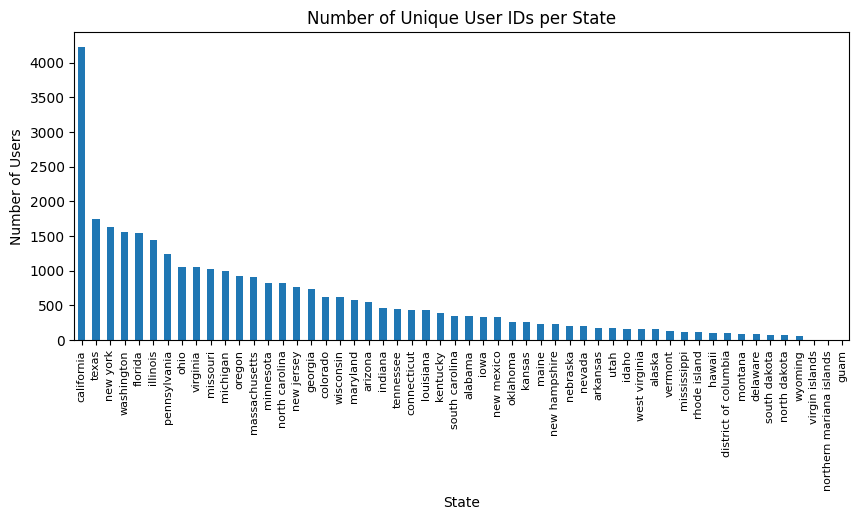

In [ ]:
# Plotting
plt.figure(figsize=(10, 4))
unique_users_per_state.plot(kind='bar')
plt.title('Number of Unique User IDs per State')
plt.xlabel('State')
plt.ylabel('Number of Users')
plt.xticks(rotation=90, fontsize=8)  # Rotates state labels for better readability
plt.show()

Average age of user: 37.6288032454361
Median age of user: 36.0


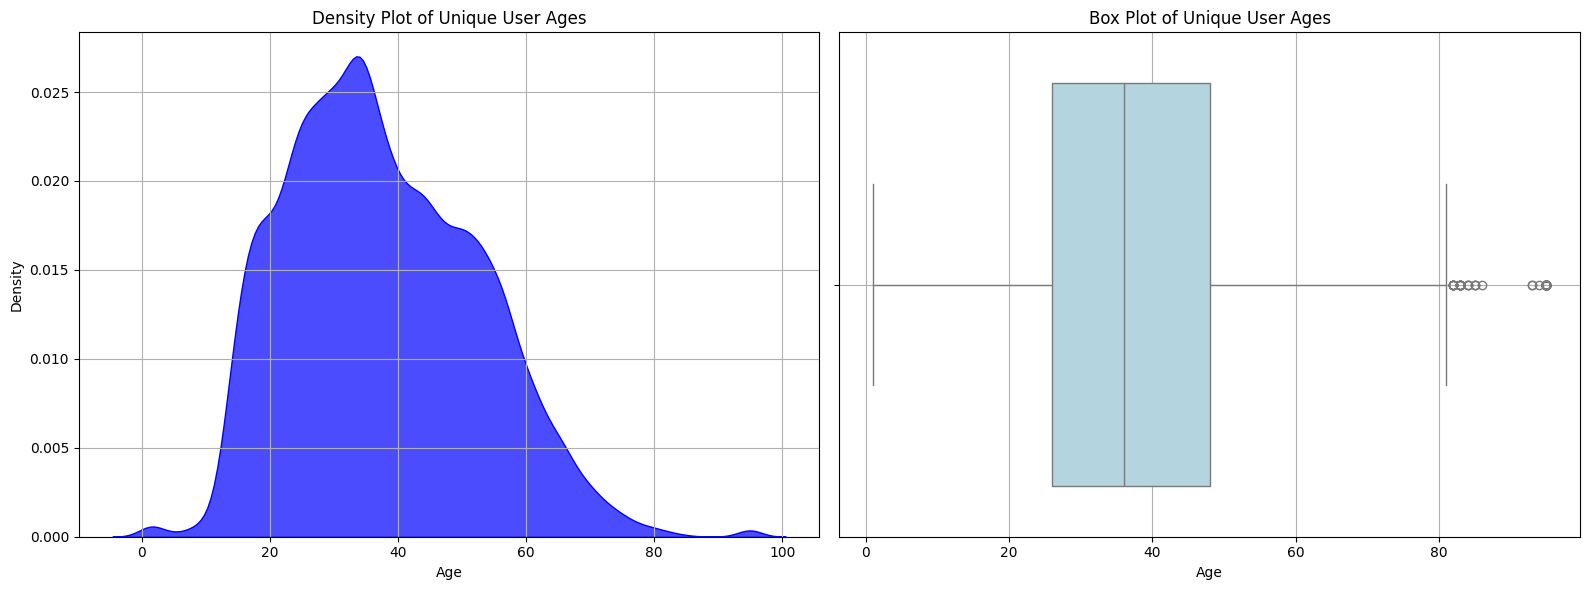

In [ ]:
# Print average, median age
avg_age = unique_users['Age'].mean()
median_age = unique_users['Age'].median()
print(f"Average age of user: {avg_age}")
print(f"Median age of user: {median_age}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Density plot on the first subplot
sns.kdeplot(unique_users['Age'], ax=axes[0], shade=True, color="b", alpha=0.7)
axes[0].set_title('Density Plot of Unique User Ages')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Box plot on the second subplot
sns.boxplot(x=unique_users['Age'], ax=axes[1], color="lightblue")
axes[1].set_title('Box Plot of Unique User Ages')
axes[1].set_xlabel('Age')
axes[1].grid(True)

# Show the plot
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

We are more interested in the distribution of ratings rather than the users themselves, so we delve deeper into the demographics of the rating data. The following analysis of ratings may contain multiple ratings from the same user.

## 2.1.1 Number of Ratings by Location

In [ ]:
# number of ratings by states
df_state = df_cleaned[['State', 'Book-Rating']].groupby(by='State', as_index=False).count()
df_state.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_state.sort_values(by='Count', ascending=False, inplace=True)
df_state

State  Count
4                 california  74721
45                     texas  34509
9                    florida  25899
26                  missouri  25425
10                   georgia  24831
50                washington  23504
49                  virginia  22101
14                  illinois  21468
33                  new york  17854
24                 minnesota  16847
34            north carolina  15744
40              pennsylvania  15319
37                      ohio  14911
21                  maryland  14719
23                  michigan  14661
31                new jersey  14573
39                    oregon  12308
2                    arizona  11203
52                 wisconsin  11102
5                   colorado  10786
44                 tennessee  10445
22             massachusetts   7976
18                  kentucky   7777
6                connecticut   7396
51             west virginia   7160
0                    alabama   6846
15                   indiana   6674
28                  nebraska   5434
42            south carolina   5395
38                  oklahoma   5218
16                      iowa   4920
30             new hampshire   4632
29                    nevada   4533
17                    kansas   4289
1                     alaska   3886
32                new mexico   3736
12                    hawaii   3701
3                   arkansas   3691
19                 louisiana   3673
25               mississippi   2781
20                     maine   2640
46                      utah   1990
43              south dakota   1415
47                   vermont   1344
13                     idaho   1334
41              rhode island   1236
27                   montana   1127
7                   delaware   1047
35              north dakota    761
53                   wyoming    660
8       district of columbia    524
48            virgin islands      3
11                      guam      2
36  northern mariana islands      1

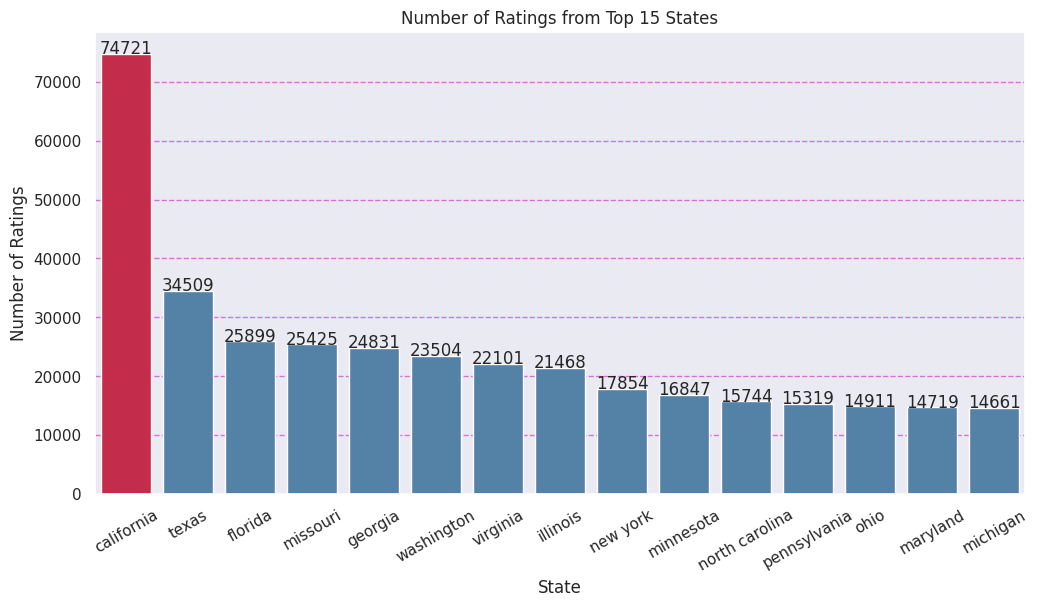

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_state = df_state['Count'][:15]
cols = ['steelblue' if (x < max(count_state)) else 'crimson' for x in count_state]

# State plot
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_state = sns.barplot(data=df_state[:15], x='State', y='Count', palette=cols)
plot_state.set_title('Number of Ratings from Top 15 States')
plt.xticks(rotation=30)
plot_state.set_xlabel('State')
plot_state.set_ylabel('Number of Ratings')
for i, v in enumerate(count_state):
    plot_state.text(i, v, str(v), ha='center')

In [ ]:
df_city = df_cleaned[['City', 'Book-Rating']].groupby(by='City', as_index=False).count()
df_city.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_city.sort_values(by='Count', ascending=False, inplace=True)
df_city.head()

City  Count
5067      st. louis   9365
925         chicago   6736
3891        olympia   6705
2943  little canada   6360
1882    ft. stewart   5797

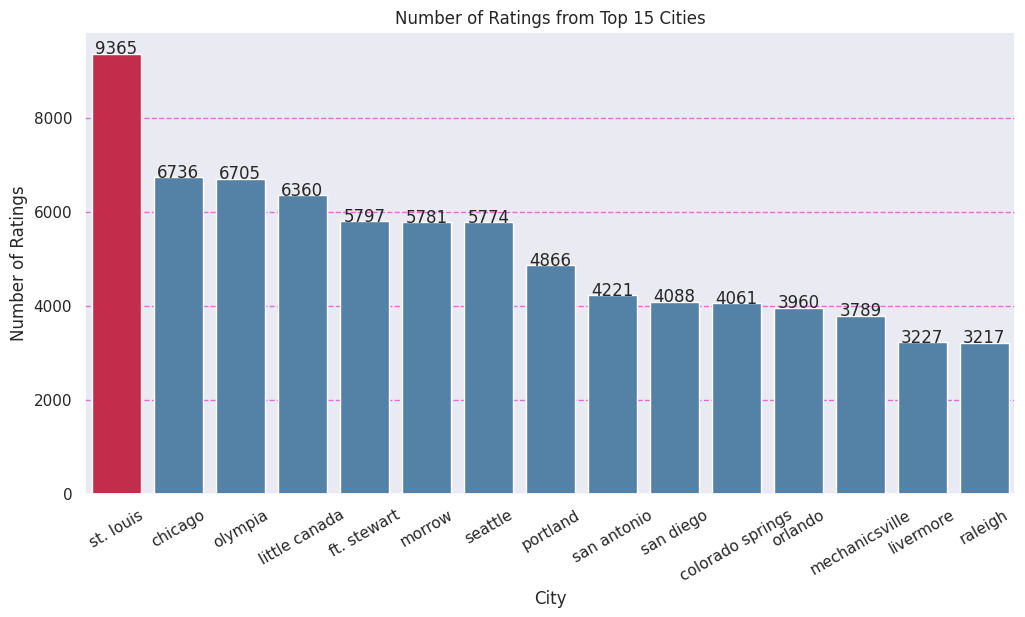

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_city = df_city['Count'][:15]
cols = ['steelblue' if (x < max(count_city)) else 'crimson' for x in count_city]

# City plot
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_city = sns.barplot(data=df_city[:15], x='City', y='Count', palette=cols)
plot_city.set_title('Number of Ratings from Top 15 Cities')
plt.xticks(rotation=30)
plot_city.set_xlabel('City')
plot_city.set_ylabel('Number of Ratings')
for i, v in enumerate(count_city):
    plot_city.text(i, v, str(v), ha='center')

In [ ]:
def age_helper(x):
    if (0 <= x < 10): return 0
    elif (10 <= x < 20): return 10
    elif (20 <= x < 30): return 20
    elif (30 <= x < 40): return 30
    elif (40 <= x < 50): return 40
    elif (50 <= x < 60): return 50
    elif (60 <= x < 70): return 60
    elif (70 <= x < 80): return 70
    elif (80 <= x < 90): return 80
    elif (90 <= x < 100): return 90
    elif (100 <= x < 110): return 100
    elif (110 <= x < 120): return 110
    elif (120 <= x < 130): return 120
    elif (130 <= x < 140): return 130
    elif (140 <= x < 150): return 140
    elif (150 <= x < 160): return 150
    elif (160 <= x < 170): return 160
    elif (170 <= x < 180): return 170
    elif (180 <= x < 190): return 180
    elif (190 <= x < 200): return 190
    elif (200 <= x < 210): return 200
    elif (210 <= x < 220): return 210
    elif (220 <= x < 230): return 220
    elif (230 <= x < 240): return 230
    else: return 'AgeError'

df_cleaned['User-Decade'] = df_cleaned['Age'].apply(age_helper)

In [ ]:
df_user_decade = df_cleaned[['User-Decade', 'Book-Rating']].groupby(by='User-Decade', as_index=False).count()
df_user_decade.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_user_decade

User-Decade   Count
0            0    3125
1           10   20951
2           20  119698
3           30  177291
4           40  120442
5           50   74585
6           60   25430
7           70    2259
8           80     609
9           90    2342

## 2.1.2 Number of Ratings By Age

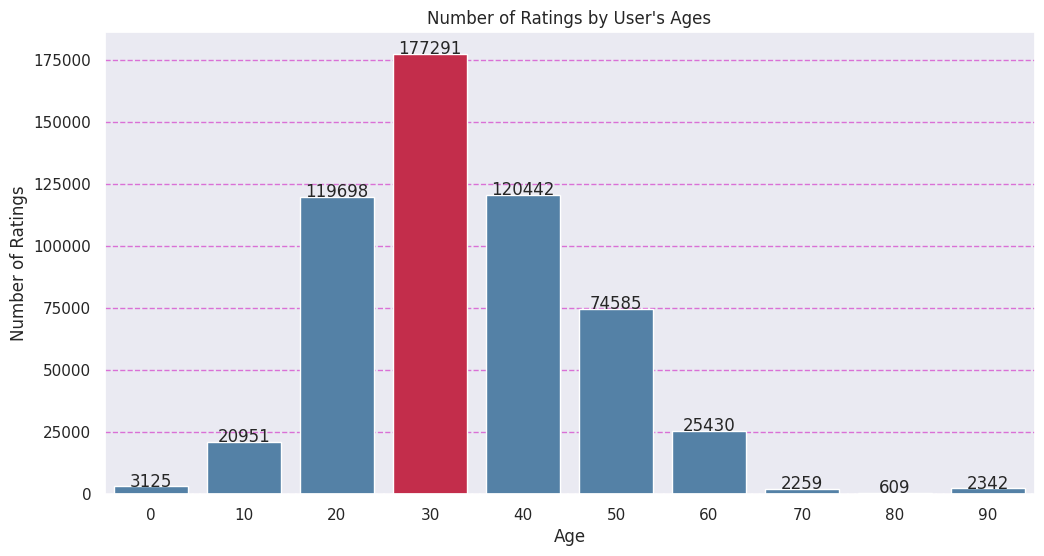

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_user_decade = df_user_decade['Count']
cols = ['steelblue' if (x < max(count_user_decade)) else 'crimson' for x in count_user_decade]

# User decade plot
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_user_decade = sns.barplot(data=df_user_decade, x='User-Decade', y='Count', palette=cols)
plot_user_decade.set_title('Number of Ratings by User\'s Ages')
plot_user_decade.set_xlabel('Age')
plot_user_decade.set_ylabel('Number of Ratings')
for i, v in enumerate(count_user_decade):
    plot_user_decade.text(i, v, str(v), ha='center')

Average age in Virgin Island: 28.0
Average age in Nothern Mariana Island: 61.0


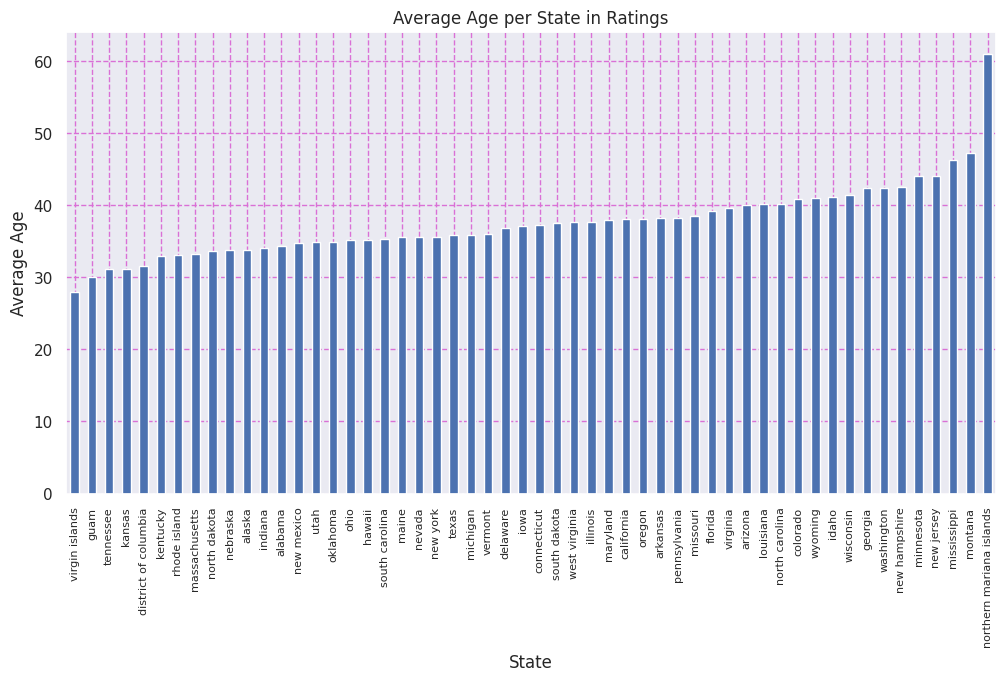

In [ ]:
# Calculate the average age per state in Ratings
avg_age_per_state = df_cleaned.groupby('State')['Age'].mean().sort_values()

print(f"Average age in Virgin Island: {avg_age_per_state['virgin islands']}")
print(f"Average age in Nothern Mariana Island: {avg_age_per_state['northern mariana islands']}")

# Plotting
plt.figure(figsize=(12, 6))
avg_age_per_state.plot(kind='bar')
plt.title('Average Age per State in Ratings')
plt.xlabel('State')
plt.ylabel('Average Age')
plt.xticks(rotation=90, fontsize=8)
plt.show()


We see a high number of ratings from California. This is in line with our expectation as we had the most unique users from California.

City-wise, we had the most ratings from St. Louis. While California is the top source of ratings state-wise, its users are more dispersed across different cities within California.

As for their age, the average age of rating is 38.20, and the median is 36, suggesting that the data follows a fairly symmetrical normal curve; there is no significant skew in the distribution. We had earlier removed any age outliers over 100. There are some ratings from age below 10,  but the number of these ratings is small, so we give the benefit of the doubt that some parents rated on behalf of their toddlers.

Interestingly, we see that the average age of rating is lowest in the Virgin Islands (28 years) and highest in the Northern Mariana Islands (61 years). This could be due to a number of factors, possibly even due to the sampling method of the dataset. Off the top of the head, we conjecture that the Northern Mariana Islands has more retired population users, whereas younger users are more prevalent in the Virgin Islands.

# 2.2. Books/Authors/Publishers

Let's review information that pertain to the books.

In [ ]:
num_unique_isbn = df_cleaned['ISBN'].nunique()
num_unique_title = df_cleaned['Book-Title'].nunique()
print(f"We have {num_unique_isbn} unique ISBNs")
print(f"We have {num_unique_title} unique titles")

We have 169074 unique ISBNs
We have 150997 unique titles


ISBN stands for International Standard Book Number. It's a unique identifier assigned to each edition and variation of a book. For example, paperback, hardcover versions of the same title will each have different ISBNs. Hence, we have more ISBNs than the number of titles, indicating that some books have the same titles but different ISBNs. For the purpose of our analysis, we will define unique books by their unique ISBN numbers.

In [ ]:
books_unique_isbn = df_cleaned.drop_duplicates(subset='ISBN', keep='first')
books_unique_isbn.describe()

User-ID            Age    Book-Rating  Year-Of-Publication  \
count  169074.000000  169074.000000  169074.000000        169074.000000   
mean   110180.553917      38.769131       2.628228          1993.660675   
std     79233.623046      12.827502       3.837531             8.084142   
min         2.000000       1.000000       0.000000          1897.000000   
25%     36836.000000      30.000000       0.000000          1989.000000   
50%     98391.000000      37.000000       0.000000          1995.000000   
75%    174304.000000      47.000000       7.000000          2000.000000   
max    278851.000000      95.000000      10.000000          2004.000000   

         User-Decade  
count  169074.000000  
mean       34.334847  
std        13.191746  
min         0.000000  
25%        30.000000  
50%        30.000000  
75%        40.000000  
max        90.000000

In [ ]:
num_authors = books_unique_isbn['Book-Author'].nunique()
num_publishers = books_unique_isbn['Publisher'].nunique()
print(f"We have {num_authors} unique authors")
print(f"We have {num_publishers} unique publishers")

We have 63172 unique authors
We have 9805 unique publishers


This number of unique records confirms that we have a fairly extensive set of books in our database without anomalies, sufficient for our modeling. Nonetheless, we continue to delve deeper into the ratings information rather than focusing on unique books.

## 2.2.1 Number of Ratings by Publication Year

As for the publication decades, we see that most ratings are of books from the 1990s or more recent, with an average publication year of 1995 and a median publication year of 1997. The similarity between the mean and median confirms that the book rating data is minimally skewed.

In [ ]:
def decade_helper(x):
    if (1890 <= x < 1900): return 1890
    elif (1900 <= x < 1910): return 1900
    elif (1910 <= x < 1920): return 1910
    elif (1920 <= x < 1930): return 1920
    elif (1930 <= x < 1940): return 1930
    elif (1940 <= x < 1950): return 1940
    elif (1950 <= x < 1960): return 1950
    elif (1960 <= x < 1970): return 1960
    elif (1970 <= x < 1980): return 1970
    elif (1980 <= x < 1990): return 1980
    elif (1990 <= x < 2000): return 1990
    elif (2000 <= x < 2010): return 2000
    elif (2010 <= x < 2020): return 2010
    elif (2020 <= x < 2030): return 2020
    elif (2030 <= x < 2040): return 2030
    elif (2040 <= x < 2050): return 2040
    elif (2050 <= x < 2060): return 2050
    else: return 'DecadeError'

df_cleaned['Year-Of-Publication'] = df_cleaned['Year-Of-Publication'].astype(int)
df_cleaned = df_cleaned[df_cleaned['Year-Of-Publication'] != 0]
df_cleaned['Decade-Of-Publication'] = df_cleaned['Year-Of-Publication'].apply(decade_helper)

In [ ]:
df_pub_decade = df_cleaned[['Decade-Of-Publication', 'Book-Rating']].groupby(by='Decade-Of-Publication', as_index=False).count()
df_pub_decade.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_pub_decade

Decade-Of-Publication   Count
0                    1890       1
1                    1900      12
2                    1910      13
3                    1920     140
4                    1930      75
5                    1940     147
6                    1950    1270
7                    1960    2210
8                    1970   14051
9                    1980   80487
10                   1990  262056
11                   2000  186270

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_pub_decade.to_csv('df_pub_decade.csv',index = True)

The average publication year is: 1995.31
The median publication year is: 1997.0


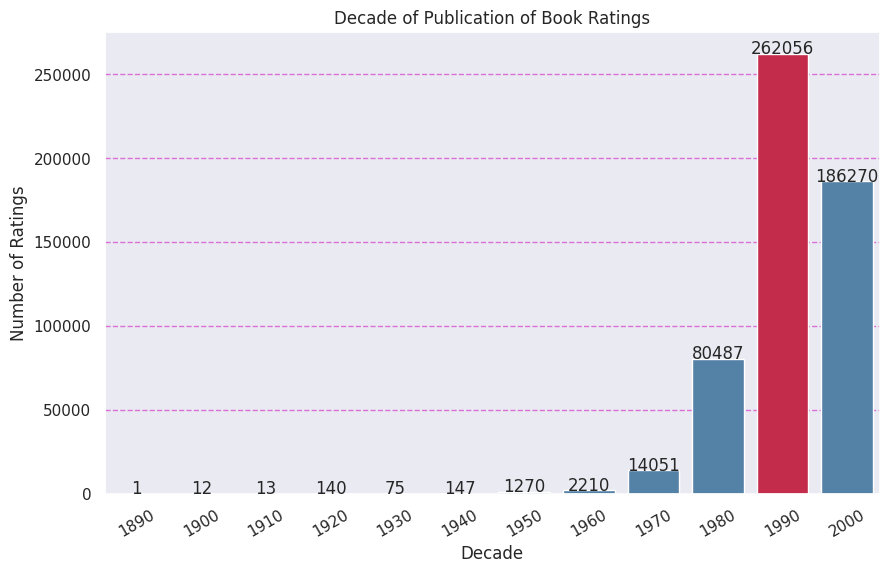

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_pub_decade = df_pub_decade['Count']
cols = ['steelblue' if (x < max(count_pub_decade)) else 'crimson' for x in count_pub_decade]

# Publication decade plot
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_pub_decade = sns.barplot(data=df_pub_decade, x='Decade-Of-Publication', y='Count', palette=cols)
plot_pub_decade.set_title('Decade of Publication of Book Ratings')
plt.xticks(rotation=30)
plot_pub_decade.set_xlabel('Decade')
plot_pub_decade.set_ylabel('Number of Ratings')
for i, v in enumerate(count_pub_decade):
    plot_pub_decade.text(i, v, str(v), ha='center')

# Calculating the average age
average_pub_year = df_cleaned['Year-Of-Publication'].mean()
median_pub_year = df_cleaned['Year-Of-Publication'].median()
print(f"The average publication year is: {average_pub_year:.2f}")
print(f"The median publication year is: {median_pub_year}")

## 2.2.2 Ages and Decades

We breakdown the book publication decades against the decades of user ages, with the counts indicating the number of books read or rated by users from different age groups.

Insights:
* The 1990s and 2000s columns have the highest counts, suggesting books from these decades are the most popular among all age groups.
* Younger readers (especially those in their 20s and 30s) are the most active, with significantly higher counts across more recent publication decades.
* Even among older publications (1960s and 1970s), it is the younger readers (20s to 40s age groups) who engage with these books the most, indicating a broad range of interests.
* There is a noticeable decline in counts as the age groups increase, particularly after the 50s. This could be due to less engagement with the platform from these age groups or lower numbers of users in these brackets.

In [ ]:
# breakdown of user age and publication decades for analysis
# row: the decades of user ages
# column: book publication decades
df_user_pub = df_cleaned[['User-Decade', 'Decade-Of-Publication', 'Book-Rating']].groupby(by=['User-Decade', 'Decade-Of-Publication'], as_index=False).count()
df_user_pub.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_user_pub = df_user_pub[(df_user_pub['Decade-Of-Publication'] > 1950) & (df_user_pub['Decade-Of-Publication'] < 2030)]
df_user_pub = pd.pivot_table(data=df_user_pub, index='User-Decade', columns='Decade-Of-Publication', values='Count', fill_value=0.0)
df_user_pub = df_user_pub[:9]
df_user_pub

Decade-Of-Publication  1960  1970   1980   1990   2000
User-Decade                                           
0                        29   115    689   1610    666
10                       98   593   3184  10518   6434
20                      567  2784  16744  59106  40073
30                      697  4070  24688  85719  61569
40                      428  3202  18471  57491  40516
50                      271  2126  11484  32721  27833
60                       93   955   4494  12554   7278
70                       14   107    292    968    875
80                        6    47    120    293    143

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_user_pub.to_csv('df_user_pub.csv',index = True)

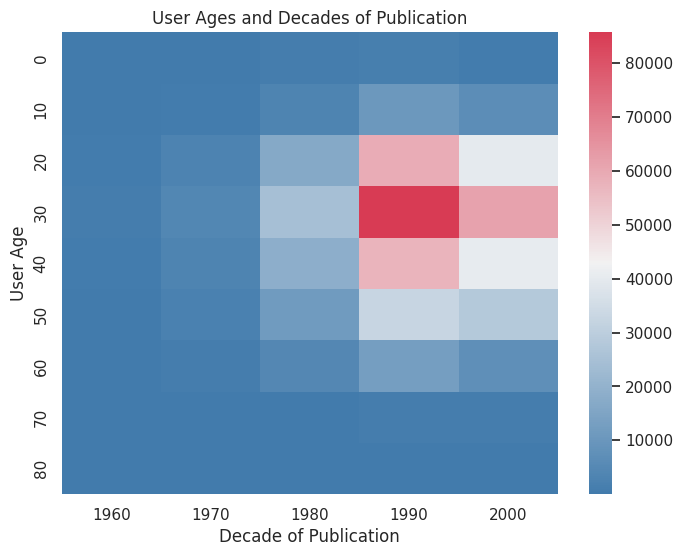

In [ ]:
# plot heatmap of user age vs. publication decades
cmap = sns.diverging_palette(243, 7, as_cmap=True)
sns.set(rc={'figure.figsize': (8, 6)})
matrix_user_pub = sns.heatmap(data=df_user_pub, fmt='g', cmap=cmap)
matrix_user_pub.set_xlabel('Decade of Publication')
matrix_user_pub.set_ylabel('User Age')
matrix_user_pub.set_title('User Ages and Decades of Publication');

## 2.2.3 Top Books by Ratings

In examining the 'Top 20 Book Titles Rated in All States vs California (Top State)', it is clear that the rating of books in California closely mirrors the overall rantings distribution (not exactly the same), highlighting California's substantial impact on the overall ratings in our database. Notably, California emerges as the leading state in terms of the rating data we have.

In [ ]:
# Show most rated book, author, number of ratings
df_title = df_cleaned[['Book-Author', 'Book-Title', 'Book-Rating']].groupby(by=['Book-Title', 'Book-Author'], as_index=False).count()
df_title.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_title.sort_values(by='Count', ascending=False, inplace=True)
df_title = df_title.reset_index()[['Book-Title', 'Book-Author', 'Count']]
df_title.head(20)

Book-Title      Book-Author  Count
0                                         Wild Animus     Rich Shapero   1014
1                           The Lovely Bones: A Novel     Alice Sebold    651
2                                   The Da Vinci Code        Dan Brown    553
3     Divine Secrets of the Ya-Ya Sisterhood: A Novel    Rebecca Wells    494
4                             The Secret Life of Bees    Sue Monk Kidd    474
5                          The Nanny Diaries: A Novel  Emma Mclaughlin    464
6                                     Angels & Demons        Dan Brown    461
7                                     A Painted House     John Grisham    426
8                               Bridget Jones's Diary   Helen Fielding    372
9                 The Red Tent (Bestselling Backlist)    Anita Diamant    372
10                                       The Notebook  Nicholas Sparks    354
11   Harry Potter and the Chamber of Secrets (Book 2)    J. K. Rowling    352
12                                         Life of Pi      Yann Martel    351
13  Harry Potter and the Sorcerer's Stone (Harry P...    J. K. Rowling    349
14                                     Summer Sisters       Judy Blume    339
15                                        The Summons     John Grisham    334
16                                           The Firm     John Grisham    325
17                                  The Pelican Brief     John Grisham    325
18                              House of Sand and Fog  Andre Dubus Iii    321
19                                   The Runaway Jury     John Grisham    319

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_title.to_csv('df_title.csv',index = True)

In [ ]:
# Show for Califonia: most rated book, number of ratings
df_title_top_state = df_cleaned[df_cleaned['State'] == 'california'][['Book-Title', 'Book-Rating']].groupby(by='Book-Title', as_index=False).count()
df_title_top_state.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_title_top_state.sort_values(by='Count', ascending=False, inplace=True)
df_title_top_state = df_title_top_state.reset_index()[['Book-Title', 'Count']]
df_title_top_state.head()

Book-Title  Count
0                                      Wild Animus    135
1                       The Nanny Diaries: A Novel     84
2  Divine Secrets of the Ya-Ya Sisterhood: A Novel     79
3                                  Angels & Demons     76
4                        The Lovely Bones: A Novel     75

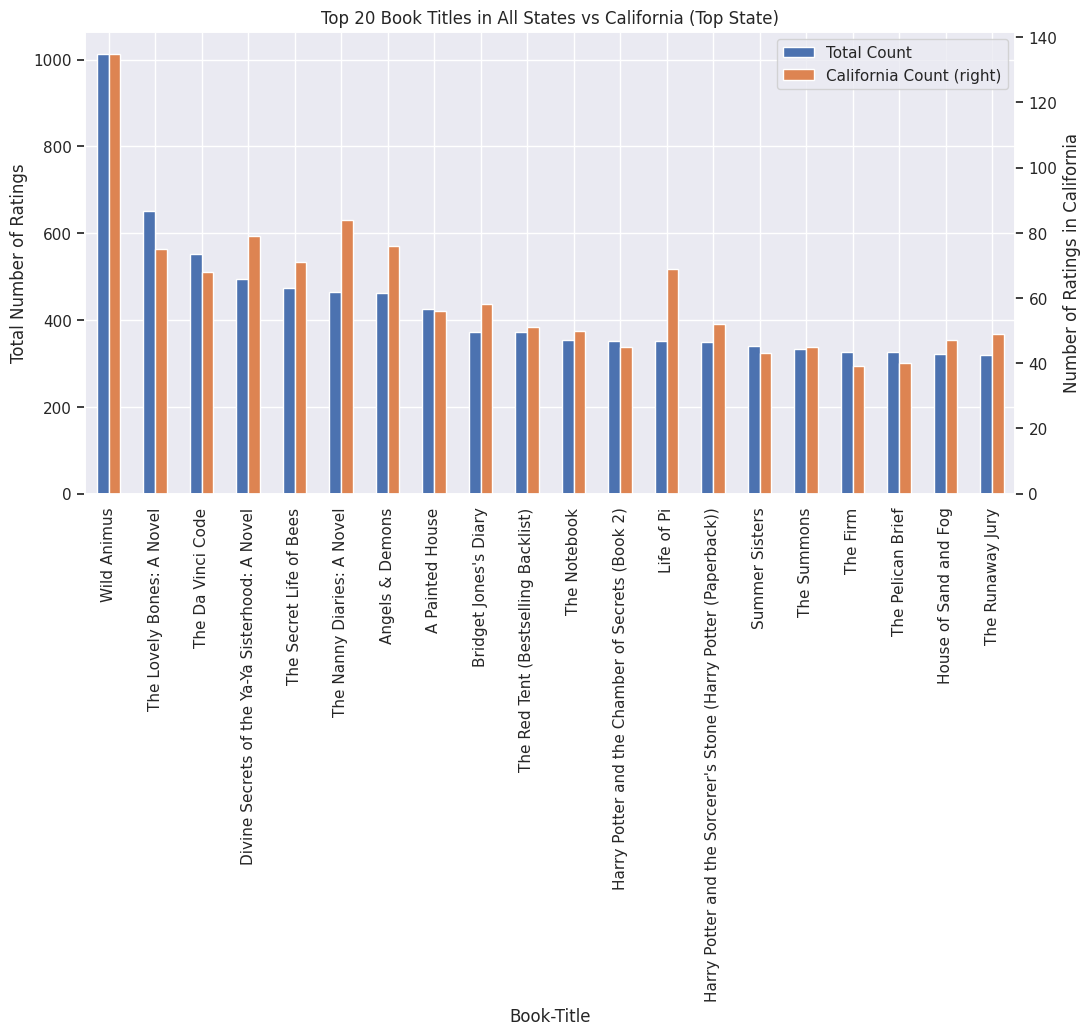

In [ ]:
# Multiple bar charts to compare top books in all states vs California
df_total_cal = pd.DataFrame({
    'Total Count': [
        df_title['Count'][0], df_title['Count'][1], df_title['Count'][2], df_title['Count'][3], df_title['Count'][4],
        df_title['Count'][5], df_title['Count'][6], df_title['Count'][7], df_title['Count'][8], df_title['Count'][9],
        df_title['Count'][10], df_title['Count'][11], df_title['Count'][12], df_title['Count'][13], df_title['Count'][14],
        df_title['Count'][15], df_title['Count'][16], df_title['Count'][17], df_title['Count'][18], df_title['Count'][19]
    ],
    'California Count': [
        df_title_top_state['Count'][0], df_title_top_state['Count'][4], df_title_top_state['Count'][7], df_title_top_state['Count'][2], df_title_top_state['Count'][5],
        df_title_top_state['Count'][1], df_title_top_state['Count'][3], df_title_top_state['Count'][9], df_title_top_state['Count'][8], df_title_top_state['Count'][11],
        df_title_top_state['Count'][12], df_title_top_state['Count'][19], df_title_top_state['Count'][6], df_title_top_state['Count'][10], df_title_top_state['Count'][28],
        df_title_top_state['Count'][23], df_title_top_state['Count'][40], df_title_top_state['Count'][37], df_title_top_state['Count'][17], df_title_top_state['Count'][13]
    ]
}, index=df_title['Book-Title'][:20])
df_total_cal.plot(kind='bar', figsize=(12, 6), secondary_y='California Count')
ax0, ax1 = plt.gcf().get_axes()
ax0.set_ylabel('Total Number of Ratings')
ax1.set_ylabel('Number of Ratings in California')
plt.title('Top 20 Book Titles in All States vs California (Top State)');

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_total_cal.to_csv('df_total_cal.csv',index = True)

## 2.2.4 Top Authors by Ratings

The followings are the most rated authors. An intriguing observation is the performance of 'Wild Animus' by Rich Shapero (as above, Top Books). Despite Shapero ranking 35th among authors, 'Wild Animus' astonishingly clinched the 1st place in number of ratings by book. This means that the top authors listed below had their ratings spread across multiple books.

In [ ]:
df_author = df_cleaned[['Book-Author', 'Book-Rating']].groupby(by='Book-Author', as_index=False).count()
df_author.rename(columns={'Book-Rating': 'Count'}, inplace=True)
df_author.sort_values(by='Count', ascending=False, inplace=True)
df_author.head()

Book-Author  Count
56421     Stephen King   5683
45491     Nora Roberts   5526
30058     John Grisham   4752
26098  James Patterson   3458
11953   Danielle Steel   3115

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_author.to_csv('df_author.csv',index = True)

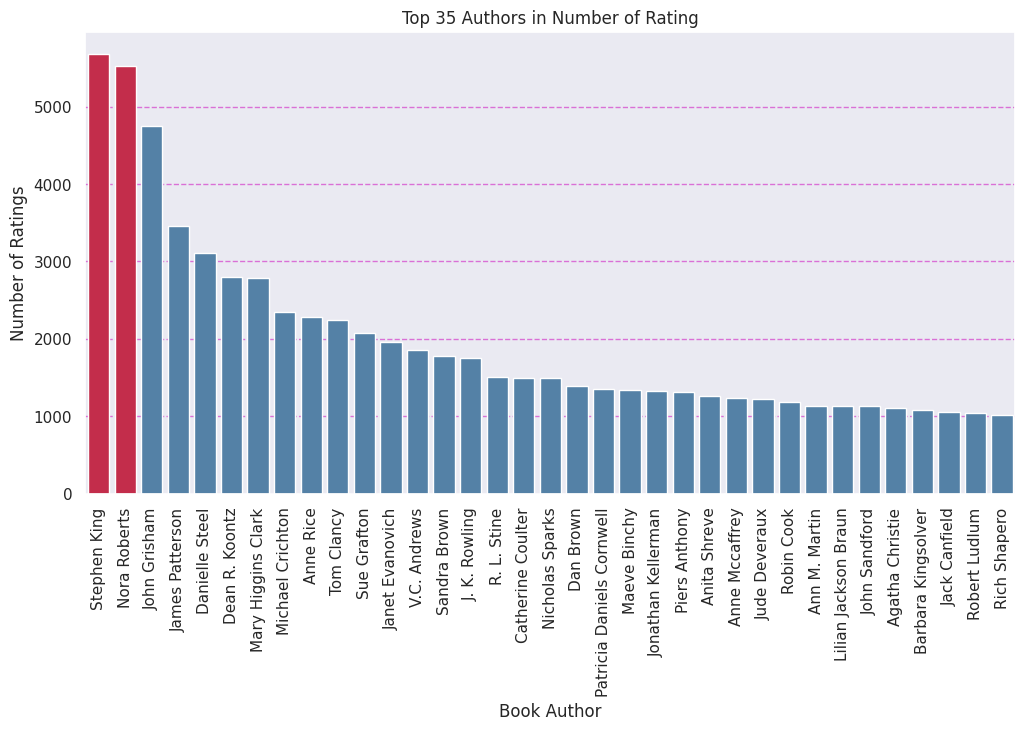

In [ ]:
# Two maximums are crimson color and the rest are steelblue color
count_author = df_author['Count'][:35]
cols = ['steelblue' if (x < list(count_author.nlargest(2))[1]) else 'crimson' for x in count_author]

# Author plot
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_author = sns.barplot(data=df_author[:35], x='Book-Author', y='Count', palette=cols)
plot_author.set_title('Top 35 Authors in Number of Rating')
plot_author.set_xticklabels(plot_author.get_xticklabels(), rotation=90)
plot_author.set_xlabel('Book Author')
plot_author.set_ylabel('Number of Ratings');

## 2.2.5 How Many Books by an Author

When delving into the question of which author has published the most books, the findings were quite surprising. Contrary to popular belief, Stephen King and Nora Roberts do not hold this title. Instead, Ann M. Martin takes the crown with an impressive 317 published books, closely followed by Francine Pascal with 310 books.

Fyi, Ann M. Martin is the author of "The Baby-Sitters Club" and other popular children's book series.

In [ ]:
df_author_title = df_cleaned[['Book-Author', 'Book-Title']]
df_author_title['Book-Title'] = df_author_title['Book-Title'].drop_duplicates()

df_author_title = df_author_title.groupby(by='Book-Author', as_index=False).count()
df_author_title.rename(columns={'Book-Title': 'Count'}, inplace=True)
df_author_title.sort_values(by='Count', ascending=False, inplace=True)
df_author_title.head()

Book-Author  Count
2688         Ann M. Martin    317
19088      Francine Pascal    309
62605  William Shakespeare    280
8224         Carolyn Keene    265
519        Agatha Christie    262

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_author_title.to_csv('df_author_title.csv',index = True)

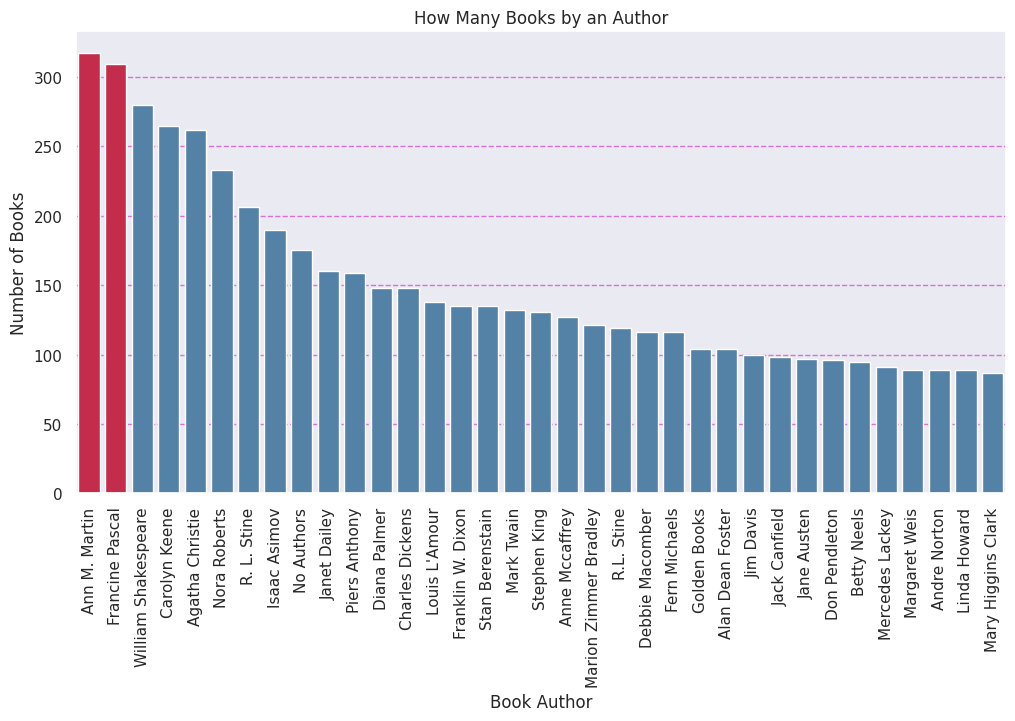

In [ ]:
# Two maximums are crimson color and the rest are steelblue color
count_author_title = df_author_title['Count'][:35]
cols = ['steelblue' if (x < list(count_author_title.nlargest(2))[1]) else 'crimson' for x in count_author_title]

# Author title plot
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})
plot_author_title = sns.barplot(data=df_author_title[:35], x='Book-Author', y='Count', palette=cols)
plot_author_title.set_title('How Many Books by an Author')
plot_author_title.set_xticklabels(plot_author_title.get_xticklabels(), rotation=90)
plot_author_title.set_xlabel('Book Author')
plot_author_title.set_ylabel('Number of Books');

## 2.2.6 Number of Ratings by Publishers
We have fairly smaller number of publishers compared to the number of authors. Review of the top publishers with the most rating reveal that they are Genre publishers.

Both Ballantine Books (part of Random House) and Pocket Books (a division of Simon & Schuster) have a history of publishing mass-market paperbacks, including a strong emphasis on genre fiction such as romance, science fiction, and fantasy. Harlequin is renowned for its focus on romance novels.

These publishers are known for producing titles that are aimed at a wide audience, often emphasizing popular fiction that appeals to a broad readership. When generalizing any interpretation from data, we should keep in mind the high proportion of genre book ratings.

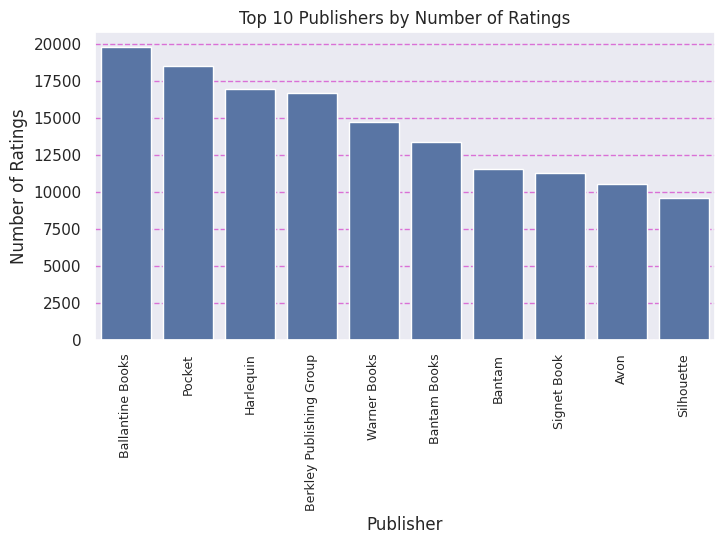

In [ ]:
# Counting the number of ratings per publisher and plotting the top 10
plt.figure(figsize=(8, 4))
top_publishers = df_cleaned['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.index, y=top_publishers.values)
plt.xticks(rotation=90, fontsize=9)
plt.title('Top 10 Publishers by Number of Ratings')
plt.xlabel('Publisher')
plt.ylabel('Number of Ratings')
plt.show()

# 2.3. Ratings

**Implicit/explicit ratings**

In the context of the review platform, an "implicit rating" refers to a type of feedback that is inferred based on user behavior rather than explicitly provided by the user. Unlike explicit ratings, where users directly assign a numerical score or star rating to a book, implicit ratings are derived from user actions that indicate preference or interest but do not explicitly quantify satisfaction.

About 66% of our data is implicit rating. We will treat this accordingly in each model.


Total number of ratings: 546732
Number of implicit ratings: 363706
Percentage of implicit ratings:  66.52


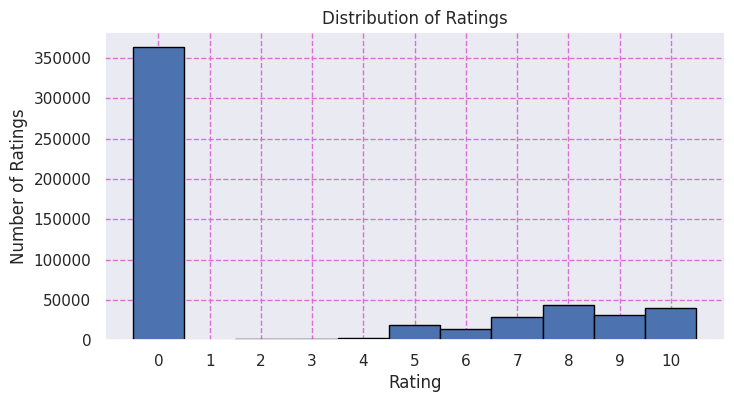

In [ ]:
num_ratings = len(df_cleaned['Book-Rating'])
implicit_ratings = df_cleaned['Book-Rating'].value_counts().get(0,0)
print(f"Total number of ratings: {num_ratings}")
print(f"Number of implicit ratings: {implicit_ratings}")
print(f"Percentage of implicit ratings: ", round(implicit_ratings/num_ratings*100,2))
# Plotting the rating histogram
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Book-Rating'], bins=range(0, 12), edgecolor='black', align='left')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(range(11))
plt.grid(True)
plt.show()

Average rating (exclusing 0) is 7.80


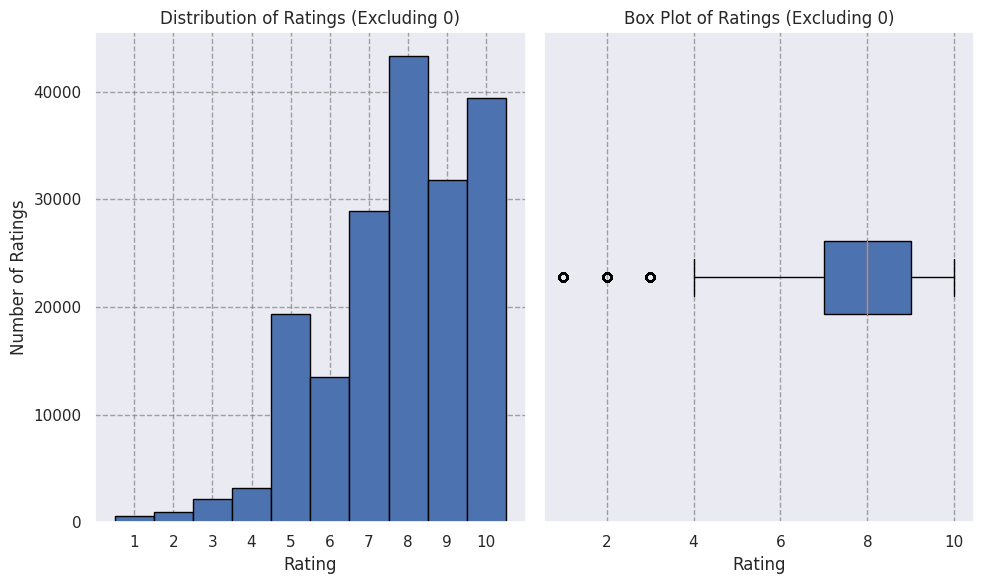

In [ ]:
# Filter out ratings that are 0
filtered_ratings = df_cleaned[df_cleaned['Book-Rating'] != 0]

avg_rating = filtered_ratings['Book-Rating'].mean()
print(f"Average rating (exclusing 0) is {avg_rating:.2f}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Histogram
axes[0].hist(filtered_ratings['Book-Rating'], bins=range(1, 12), edgecolor='black', align='left')
axes[0].set_title('Distribution of Ratings (Excluding 0)')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_xticks(range(1, 11))
axes[0].grid(True, linestyle='--', color='gray', alpha=0.7)

# Box plot
axes[1].boxplot(filtered_ratings['Book-Rating'], vert=False, patch_artist=True)
axes[1].set_title('Box Plot of Ratings (Excluding 0)')
axes[1].set_xlabel('Rating')
axes[1].set_yticks([])
axes[1].grid(True, linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()


Excluding the implicit ratings, the distribution of ratings is as shown above with an average rating of 7.8. We see that people tend to rate books highly when they do leave a explicit rating.

## 2.3.1 Book Ratings and User Decades

In terms of explicit ratings, it can be observed that most users' ratings are on par with the average, except that users over 80 tend to give slightly lower ratings.

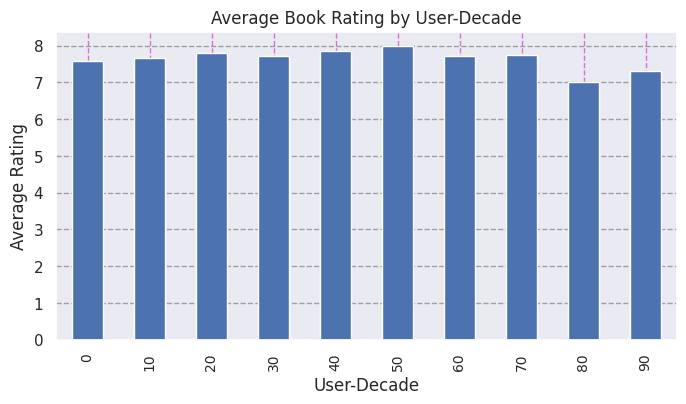

In [ ]:
# Group by 'User-Decade' and calculate the average rating
average_ratings = filtered_ratings.groupby('User-Decade')['Book-Rating'].mean()

# Plotting
plt.figure(figsize=(8,4))
average_ratings.plot(kind='bar')
plt.title('Average Book Rating by User-Decade')
plt.xlabel('User-Decade')
plt.ylabel('Average Rating')
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.show()

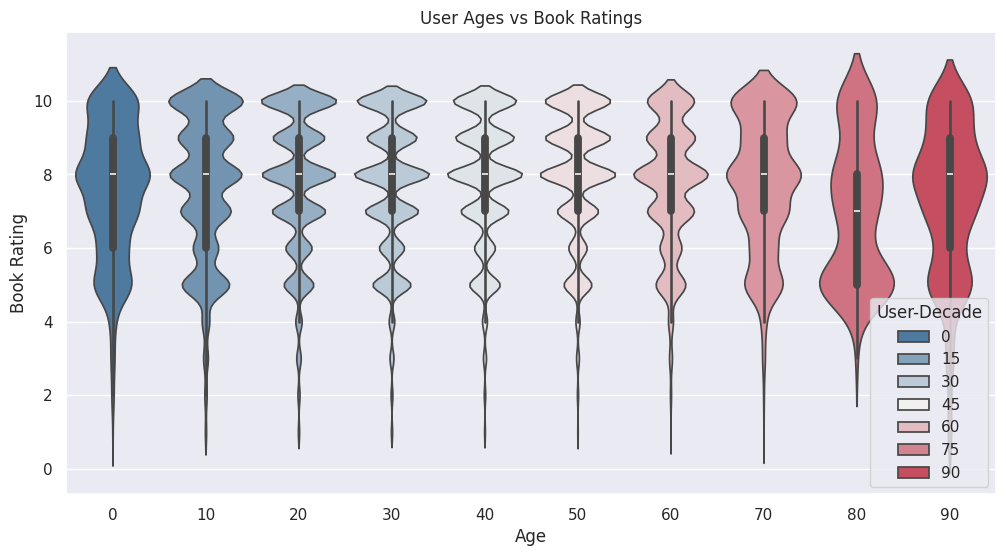

In [ ]:
df_user_rating = df_cleaned[['User-Decade', 'Book-Rating']]
df_user_rating = df_user_rating[df_user_rating['Book-Rating'] != 0]

# Rating violinplot
sns.set(rc={'figure.figsize': (12, 6)})
violinplot_rating = sns.violinplot(
    data=df_user_rating,
    x='User-Decade',
    y='Book-Rating',
    hue='User-Decade',
    hue_order=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230],
    palette=cmap
)
violinplot_rating.set_title('User Ages vs Book Ratings')
violinplot_rating.set_xlabel('Age')
violinplot_rating.set_ylabel('Book Rating');

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_user_rating.to_csv('df_user_rating.csv',index = True)

This violin plot provides a visual representation of user ages alongside the distribution of their explicit book ratings. The plot reveals an interesting age-related trend in rating behavior. Users in their teens are observed to give higher ratings on average, indicating a possible trend of more positive engagement with the books they choose to rate. In contrast, users in their 80s show a tendency to give lower ratings, suggesting a more critical or discerning approach to their ratings. Interestingly, this trend appears to revert to the mean with users in their 90s, who on average rate books similarly to the general population. This visualization effectively highlights how user engagement and rating patterns may vary significantly across different age groups.

## 2.3.2 Book Ratings and Decades of Publication

It can also be observed that people generally tend to give lower ratings to older books, those printed before 1940s. Note that we have chosen to use 'boxplot' (instead of 'violinplot') to focus more intensively on the median value.

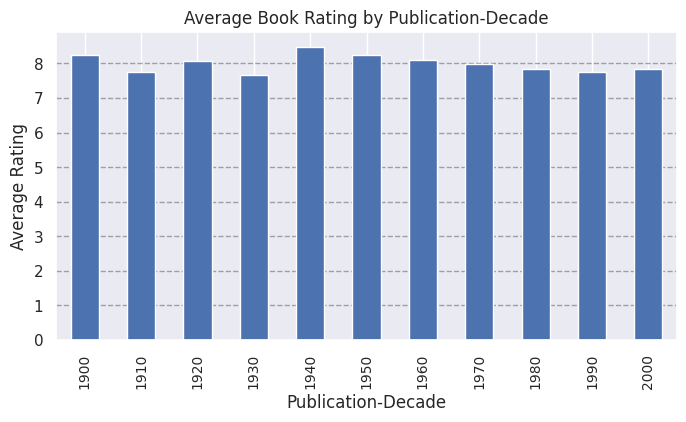

In [ ]:
# Group by publication decades and calculate the average rating
average_ratings = filtered_ratings.groupby('Decade-Of-Publication')['Book-Rating'].mean()

# Plotting
plt.figure(figsize=(8,4))
average_ratings.plot(kind='bar')
plt.title('Average Book Rating by Publication-Decade')
plt.xlabel('Publication-Decade')
plt.ylabel('Average Rating')
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.show()

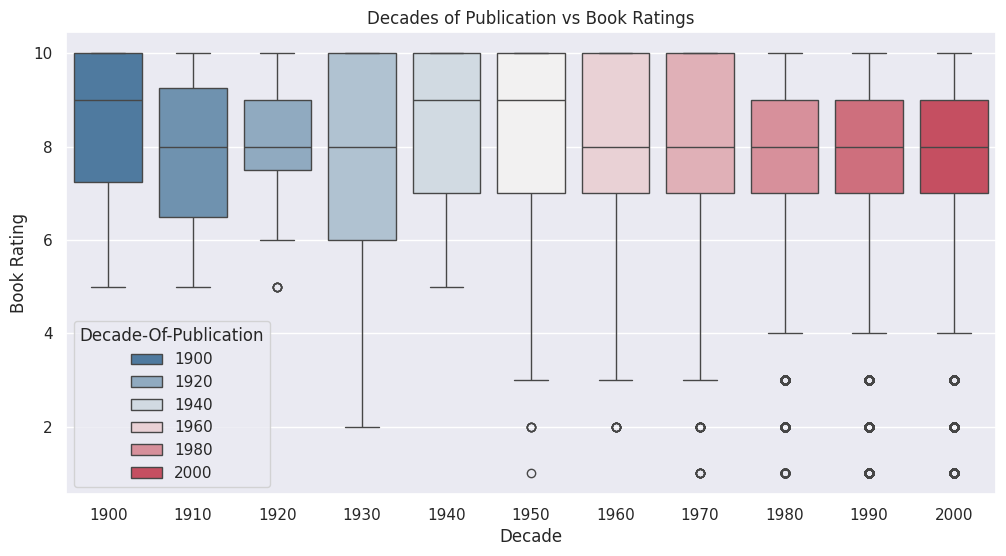

In [ ]:
df_pub_rating = df_cleaned[['Decade-Of-Publication', 'Book-Rating']]
df_pub_rating = df_pub_rating[df_pub_rating['Book-Rating'] != 0]

# Rating boxplot
sns.set(rc={'figure.figsize': (12, 6)})
boxplot_rating = sns.boxplot(
    data=df_pub_rating,
    x='Decade-Of-Publication',
    y='Book-Rating',
    hue='Decade-Of-Publication',
    hue_order=[1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030],
    palette=cmap
)
boxplot_rating.set_title('Decades of Publication vs Book Ratings')
boxplot_rating.set_xlabel('Decade')
boxplot_rating.set_ylabel('Book Rating');

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_pub_rating.to_csv('df_pub_rating.csv',index = True)

This plot provides a visual summary of how book ratings are distributed across different publication decades and can help identify trends in reader preferences or rating behaviors over time.

As time progresses, rating scores become more consistent. 1980s and 2000s decades appear to have the most consistent ratings, with the smallest interquartile ranges, suggesting less variance in how books from these decades were rated. Older books from decades before 1940s seem to have more variance in ratings.

## 2.3.3 Average Rating Per State

Upon examining the average ratings per state in explicit ratings, it is apparent that users from the Northern Mariana Islands tend to give lower ratings, significantly below the overall average. This observation aligns with a previous finding that indicated the Northern Mariana Islands have the highest average user age in the dataset. This pattern suggests a potential correlation between the age of the users and their rating behavior, implying that older users may rate books more critically, or have different standards or tastes that influence their ratings. Further analysis could be conducted to explore this relationship.

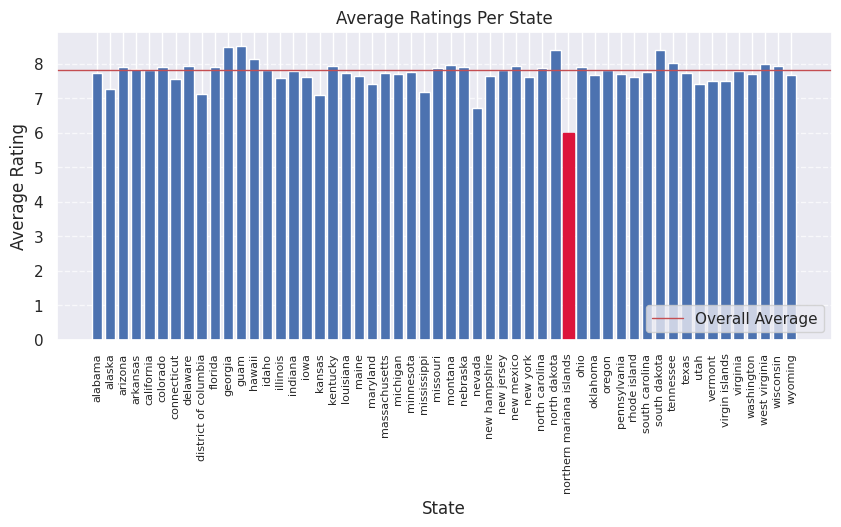

In [ ]:
# Grouping by state and calculating the average rating
average_ratings_per_state = filtered_ratings.groupby('State')['Book-Rating'].mean()

# Calculate the overall average rating
overall_average_rating = filtered_ratings['Book-Rating'].mean()

# Plotting
plt.figure(figsize=(10,4))
bars = plt.bar(average_ratings_per_state.index, average_ratings_per_state.values)

plt.title('Average Ratings Per State')
plt.xlabel('State')
plt.ylabel('Average Rating')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Find the index of the Northern Mariana Islands bar
nmi_index = average_ratings_per_state.index.get_loc("northern mariana islands")

# Change the color of the Northern Mariana Islands bar
bars[nmi_index].set_color('crimson')

# Add a horizontal line at the overall average rating
plt.axhline(y=overall_average_rating, color='r', linestyle='-', linewidth=1, label='Overall Average')
plt.legend(loc='lower right')
plt.show()

## 2.3.4 Correlation Between Ratings and Other Factors

Building on the previous discussion, we examine the correlation between ratings and other factors such as age and location (state), provided that an explicit rating is given.

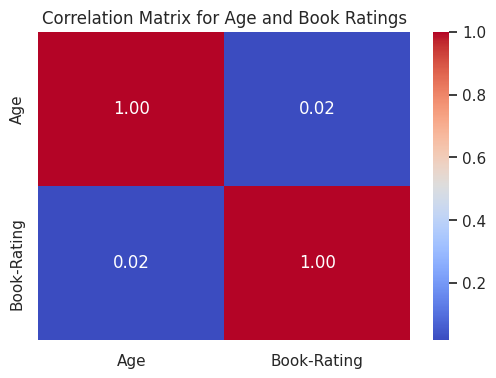

In [ ]:
# Calculate correlation matrix between age and rating
correlation_matrix = filtered_ratings[['Age', 'Book-Rating']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Age and Book Ratings')
plt.show()

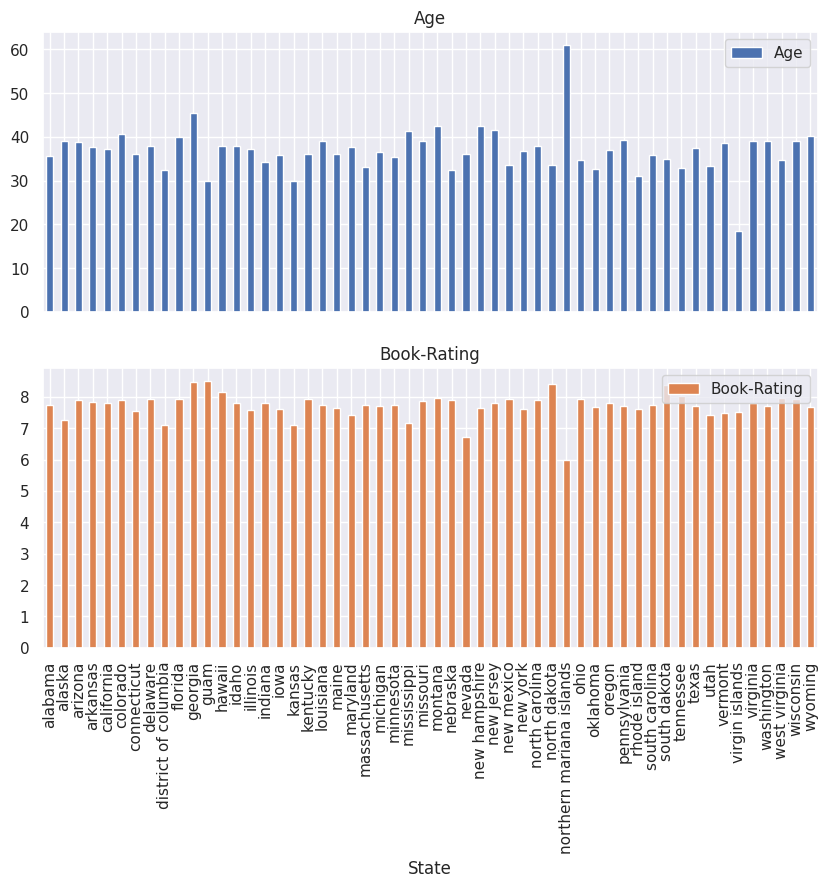

In [ ]:
# Group by state and calculate mean age and ratings
state_grouped = filtered_ratings.groupby('State')[['Age', 'Book-Rating']].mean()
state_grouped.plot(kind='bar', subplots=True, figsize=(10, 8))
plt.show()

In [ ]:
# Fit an ANOVA model
import statsmodels.api as sm
from statsmodels.formula.api import ols

# column needs to be renamed to remove hyphen
filtered_ratings.rename(columns={'Book-Rating': 'rating'}, inplace=True)

model = ols('rating ~ C(State)', data=filtered_ratings).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq        df          F  PR(>F)
C(State)   12280.087523      53.0  71.709531     0.0
Residual  591198.530252  182972.0        NaN     NaN


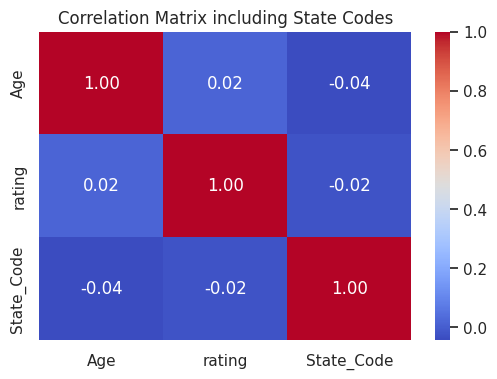

In [ ]:
# convert state to category type and then to coded numbers
filtered_ratings['State_Code'] = filtered_ratings['State'].astype('category').cat.codes

# calculate correlation matrix with this new numeric code for State
plt.figure(figsize=(6,4))
correlation_matrix = filtered_ratings[['Age', 'rating', 'State_Code']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including State Codes')
plt.show()

We did not find correlation between age and rating.

As for the relationship between State and rating, the low p-value (0.0), and high F-value in ANOVA table suggest that 'State' plays a significant role in influencing the dependent variable, rating. This could mean that different states have different average ratings, possibly due to regional preferences, cultural differences, or other socio-economic factors affecting user behavior. This fact needs to be further considered in our development of an effective recommender system.

However, the correlation matrix with states converted to numeric codes does not replicate a significant linear relationship between age and state code (representing the categorical variable State). Our lack of statistical knowledge leaves us befuddled at this point. Perhaps such encoding of a categorical variable does not capture the underlying relationships.

# 2.4. Count vs Average

We review the relationship between the number of ratings and the average ratings for several reasons. One is to identify trends. This analysis helps distinguish between popularity and quality. A book or author might receive a high volume of ratings simply because it is popular or widely marketed, not necessarily because it is of high quality. Conversely, a book with fewer ratings might have a high average rating, indicating that it is well-regarded among a smaller group of readers.

For recommendation systems, understanding this relationship can help balance suggestions between popular books and those that are highly rated but less known.

### 2.4.1. Count Rating vs Average Rating (Author)

We find that number of ratings does not match the quality of rating.

Number One in Ratings (Author):

* Stephen King stands out in the Count Rating Category, suggesting his works are frequently rated. However, for the Average Rating Category, J. K. Rowling surpasses others, indicating her books, on average, receive higher ratings from readers.

Note that the rating scale ranges from 0 to 10. In this section, we chose to include both implicit (0) ratings and explicit ratings because we wanted to capture all user interactions with the book.

In [ ]:
df_author_rating = df_cleaned[['Book-Author', 'User-ID', 'Book-Rating']].groupby(by='Book-Author', as_index=False).agg({'User-ID': 'count', 'Book-Rating': 'mean'})
df_author_rating.rename(columns={'User-ID': 'Count', 'Book-Rating': 'Average'}, inplace=True)
df_author_rating.sort_values(by='Count', ascending=False, inplace=True)
df_author_rating.head()

Book-Author  Count   Average
56421     Stephen King   5683  3.583319
45491     Nora Roberts   5526  2.593196
30058     John Grisham   4752  2.922980
26098  James Patterson   3458  2.968768
11953   Danielle Steel   3115  1.815409

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_author_rating.to_csv('df_author_rating.csv',index = True)

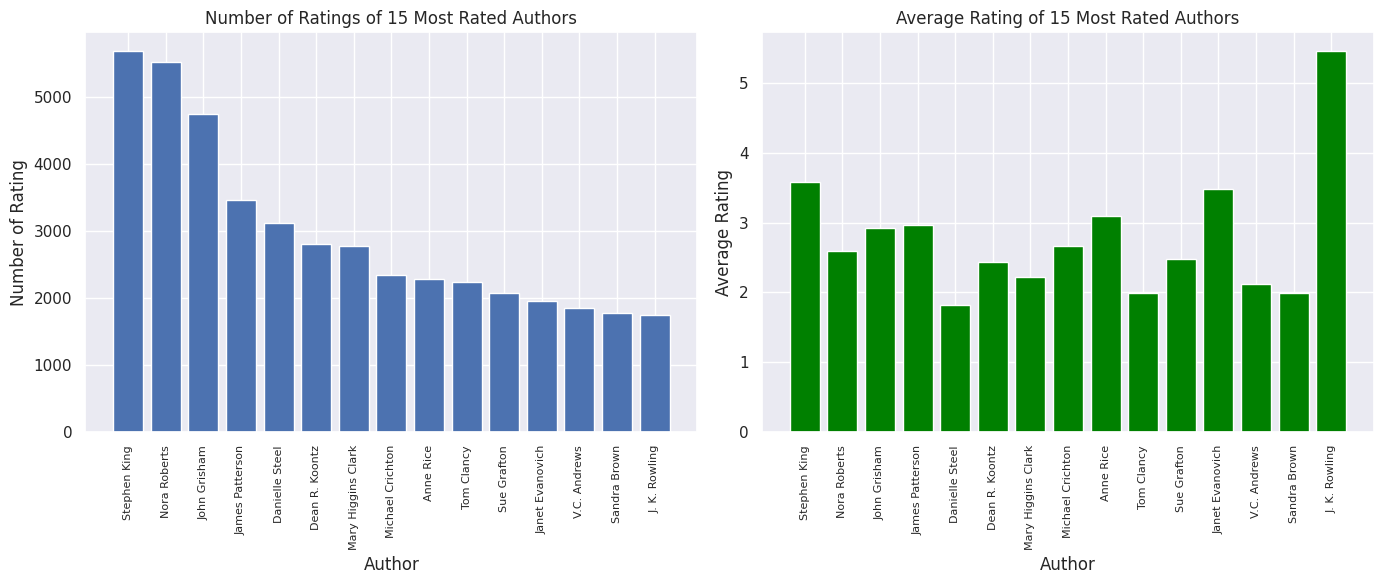

In [ ]:
top_authors = df_author_rating.head(15)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# Count of ratings
axes[0].bar(top_authors['Book-Author'], top_authors['Count'])
axes[0].set_title('Number of Ratings of 15 Most Rated Authors')
axes[0].set_xticklabels(top_authors['Book-Author'], rotation=90, fontsize=8)
axes[0].set_xlabel('Author')
axes[0].set_ylabel('Number of Rating')

# Average ratings
axes[1].bar(top_authors['Book-Author'], top_authors['Average'], color='green')
axes[1].set_title('Average Rating of 15 Most Rated Authors')
axes[1].set_xticklabels(top_authors['Book-Author'], rotation=90, fontsize=8)
axes[1].set_xlabel('Author')
axes[1].set_ylabel('Average Rating')

plt.tight_layout()
plt.show()

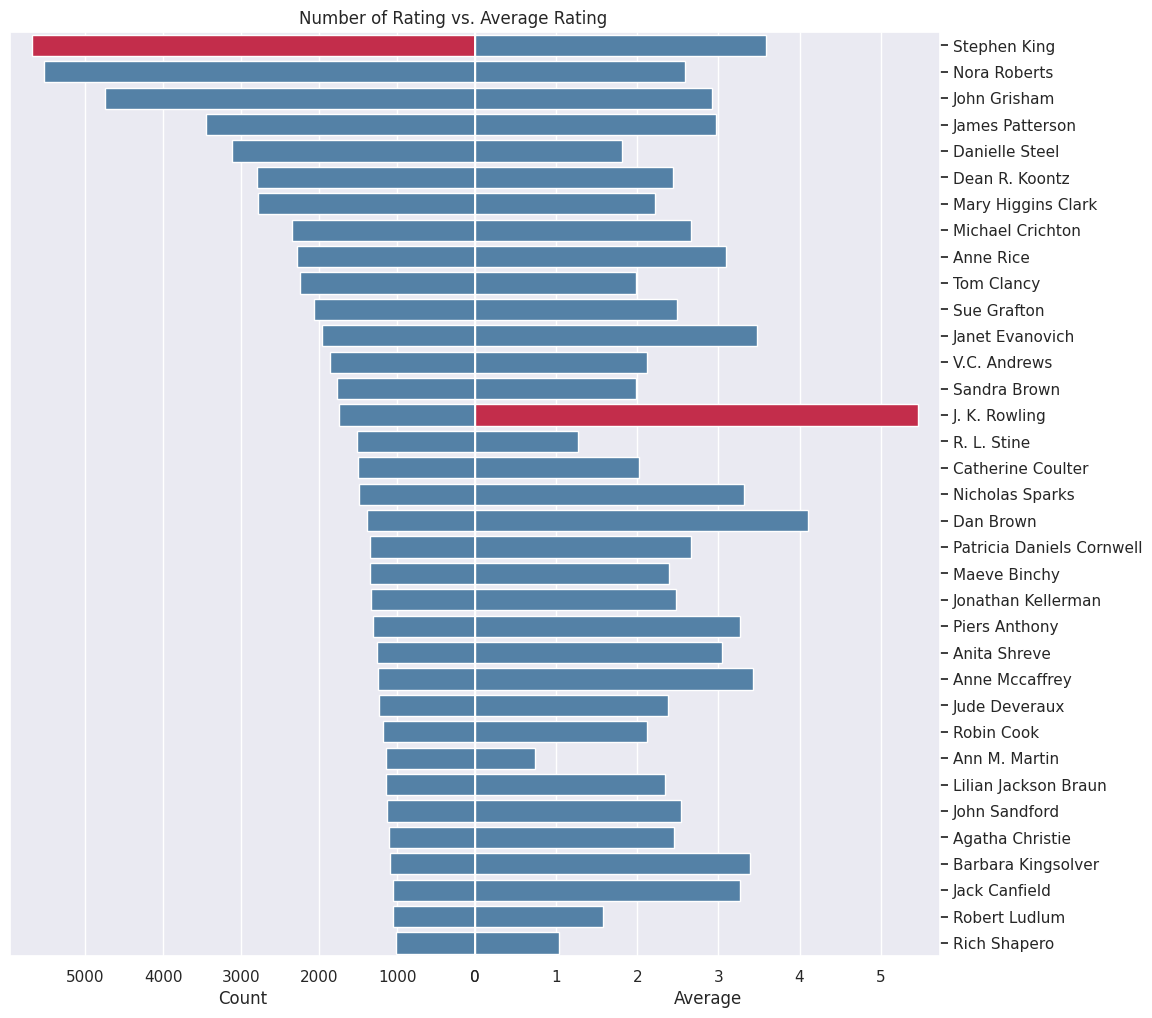

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_author_rating = df_author_rating['Average'][:35]
cols_author_rating = ['steelblue' if (x < max(count_author_rating)) else 'crimson' for x in count_author_rating]
cols_author_count = ['steelblue' if (x < max(count_author)) else 'crimson' for x in count_author]

# 2 subplots
_, (plot_author_count, plot_author_average) = plt.subplots(ncols=2, figsize=(12, 12), sharey=True, gridspec_kw={'wspace': 0})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})

# Author average plot
plot_author_average = sns.barplot(data=df_author_rating[:35], x='Average', y='Book-Author', orient='y', palette=cols_author_rating, ax=plot_author_average)
plot_author_average.tick_params(labelright=True, right=True)
plot_author_average.set_title(' Average Rating', loc='left')

# Author count plot
plot_author_count = sns.barplot(data=df_author_rating[:35], x='Count', y='Book-Author', orient='y', palette=cols_author_count, ax=plot_author_count)
plot_author_count.invert_xaxis()
plot_author_count.tick_params(labelleft=False, left=False)
plot_author_count.set_ylabel('')
plot_author_count.set_title('Number of Rating vs.', loc='right')
plt.show()

### 2.4.2. Count Rating vs Average Rating (Title)

Focusing on individual titles, 'Wild Animus' again makes a notable appearance in the Count Rating Category, underscoring its popularity. Yet its average rating was 1. This shows that the popularity of a book does not always correlate with a high rating. Meanwhile, 'Hary Potter and the Chamber of Secrets (Book 2)' secures the top spot in the Average Rating Category, reflecting its acclaim among readers.

In [ ]:
df_title_rating = df_cleaned[['Book-Title', 'User-ID', 'Book-Rating']].groupby(by='Book-Title', as_index=False).agg({'User-ID': 'count', 'Book-Rating': 'mean'})
df_title_rating.rename(columns={'User-ID': 'Count', 'Book-Rating': 'Average'}, inplace=True)
df_title_rating.sort_values(by='Count', ascending=False, inplace=True)
df_title_rating.head()

Book-Title  Count   Average
147166                                      Wild Animus   1014  1.034517
121973                        The Lovely Bones: A Novel    651  4.281106
113084                                The Da Vinci Code    553  4.654611
32441   Divine Secrets of the Ya-Ya Sisterhood: A Novel    494  3.325911
129034                          The Secret Life of Bees    474  4.468354

In [ ]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# df_title_rating.to_csv('df_title_rating.csv',index = True)

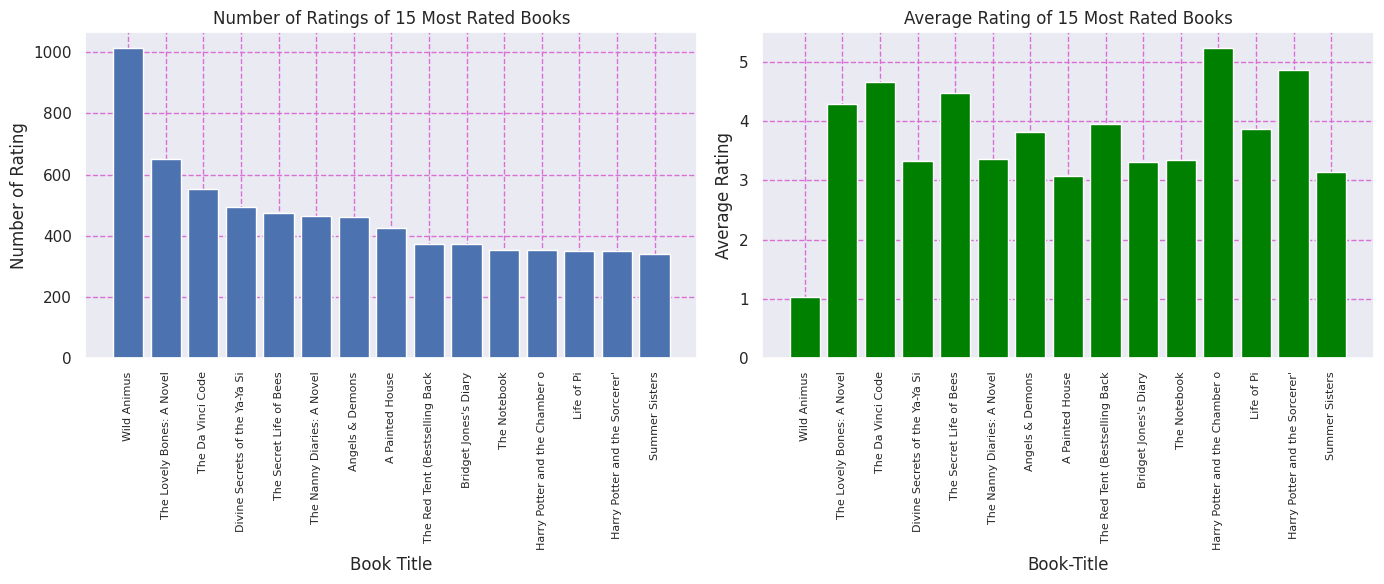

In [ ]:
top_titles = df_title_rating.head(15)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# Count of ratings
axes[0].bar(top_titles['Book-Title'], top_titles['Count'])
axes[0].set_title('Number of Ratings of 15 Most Rated Books')

# Extracting the first 30 characters of each book title
shortened_titles = [title[:30] for title in top_titles['Book-Title']]

axes[0].set_xticklabels(shortened_titles, rotation=90, fontsize=8)
axes[0].set_xlabel('Book Title')
axes[0].set_ylabel('Number of Rating')

# Average ratings
axes[1].bar(top_titles['Book-Title'], top_titles['Average'], color='green')
axes[1].set_title('Average Rating of 15 Most Rated Books')
axes[1].set_xticklabels(shortened_titles, rotation=90, fontsize=8)
axes[1].set_xlabel('Book-Title')
axes[1].set_ylabel('Average Rating')

plt.tight_layout()
plt.show()

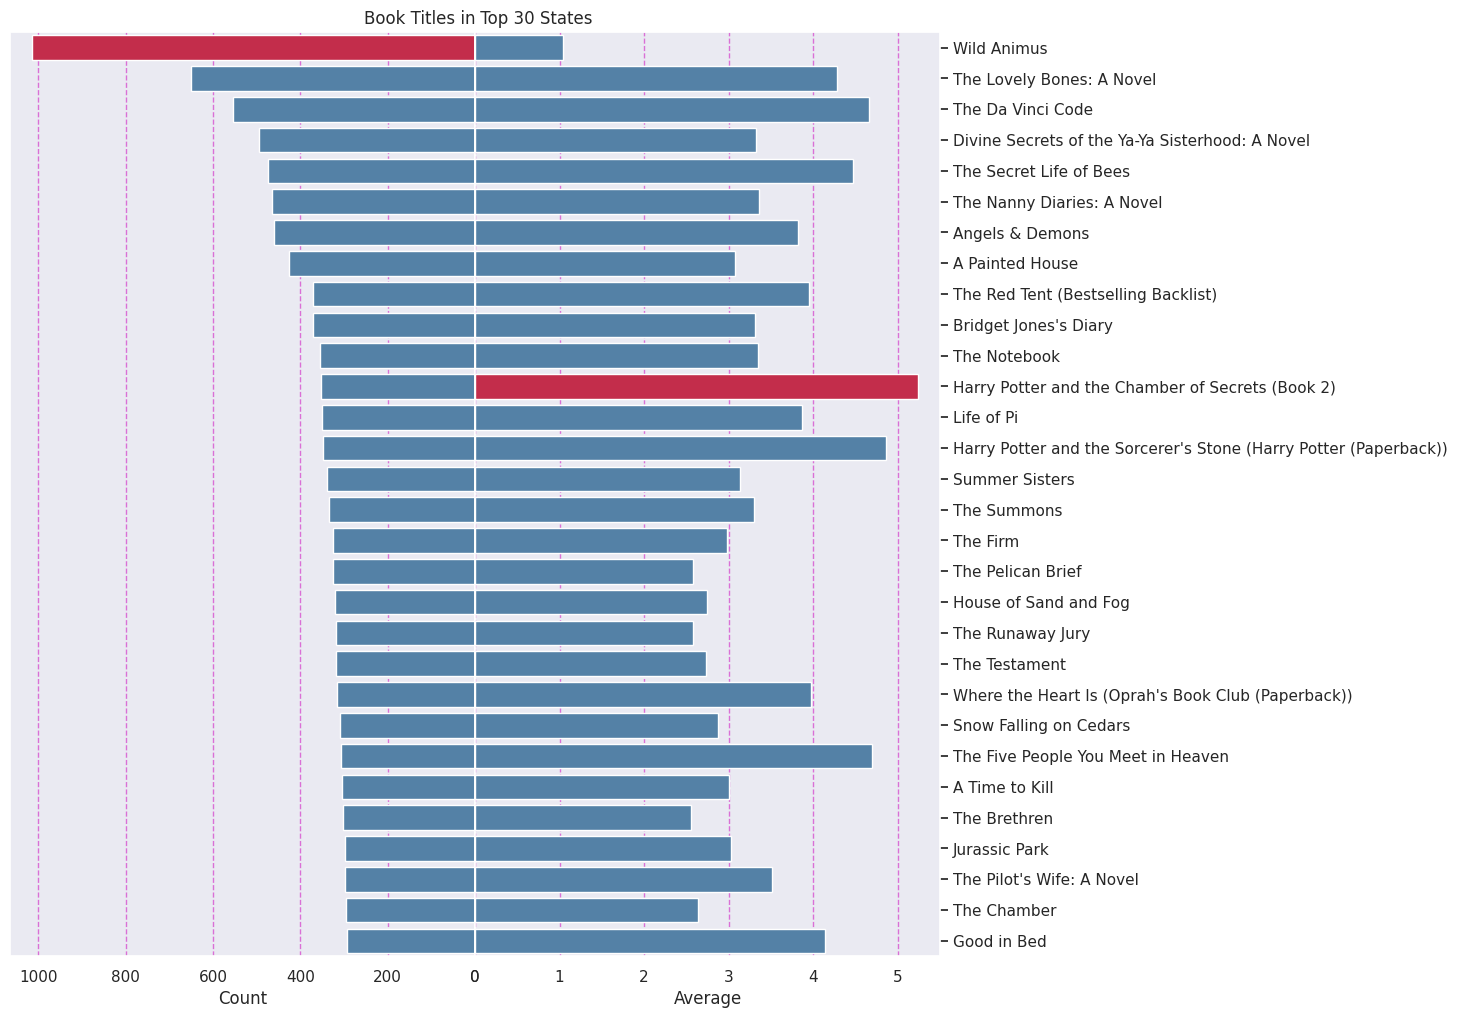

In [ ]:
# One maximum is crimson color and the rest are steelblue color
count_title_rating = df_title_rating['Average'][:30]
count_title = df_title['Count'][:30]
cols_title_rating = ['steelblue' if (x < max(count_title_rating)) else 'crimson' for x in count_title_rating]
cols_title_count = ['steelblue' if (x < max(count_title)) else 'crimson' for x in count_title]

# 2 subplots
_, (plot_title_count, plot_title_average) = plt.subplots(ncols=2, figsize=(12, 12), sharey=True, gridspec_kw={'wspace': 0})
sns.set_style('darkgrid', {'grid.color': 'orchid', 'grid.linestyle': 'dashed'})

# Title average plot
plot_title_average = sns.barplot(data=df_title_rating[:30], x='Average', y='Book-Title', orient='y', palette=cols_title_rating, ax=plot_title_average)
plot_title_average.tick_params(labelright=True, right=True)
plot_title_average.set_title(' Top 30 States', loc='left')

# Title count plot
plot_title_count = sns.barplot(data=df_title_rating[:30], x='Count', y='Book-Title', orient='y', palette=cols_title_count, ax=plot_title_count)
plot_title_count.invert_xaxis()
plot_title_count.tick_params(labelleft=False, left=False)
plot_title_count.set_ylabel('')
plot_title_count.set_title('Book Titles in', loc='right')
plt.show()

In conclusion, our exploratory data analysis of the dataset has provided valuable insights into the distribution and characteristics of user ratings. We observed a wide range of ratings across the dataset, with the majority of books receiving an implicit rating of 0, indicating interest but an absence of a numeric rating. Furthermore, our analysis revealed intriguing trends, such as the disparity between popularity and rating, suggesting that a book's widespread appeal does not necessarily guarantee a high rating. Additionally, we identified a potential correlation between a user's state of residence and their rating behavior.

These findings underscore the complexity of user preferences and highlight the importance of further investigation into the factors influencing book ratings. Overall, our EDA lays a solid foundation for book recommendation strategies.

# Model Design

Our exploratory data analysis (EDA) revealed that the factors influencing user preferences are complex. A prominent indicator of user preference is ratings. Therefore, we begin with a model that uses user ratings as a foundation.

Overall, we examine the following machine learning recommender systems:
* Collaborative filtering
* Neural networks
* Clustering
* Natural Language Processing (NLP)

# 3.0. Model Dataset Creation

For the purposes of the collaborative filtering recommendation algorithm, we will only be using the users ratings to compute the results.  For this reason, we want to include as many possible records to ensure we can create the most comprehensive embeddings of the books available from the data.  In contrast to the the EDA, we will encorporate the entire universe of complete data into our model, for example, we will not want to filter out users for whom we don't know their age/location.  Here, we create the datasets that will train the recommendation models.

In [ ]:
all_ratings = df_users.merge(df_ratings, how='inner', on='User-ID').merge(df_books, how='inner', on='ISBN')
all_ratings = all_ratings[['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Book-Rating']]
all_ratings.head()

User-ID        ISBN           Book-Title           Book-Author  Book-Rating
0        2  0195153448  Classical Mythology    Mark P. O. Morford            0
1        8  0002005018         Clara Callan  Richard Bruce Wright            5
2    11400  0002005018         Clara Callan  Richard Bruce Wright            0
3    11676  0002005018         Clara Callan  Richard Bruce Wright            8
4    41385  0002005018         Clara Callan  Richard Bruce Wright            0

In [ ]:
# Split into explicit and implicit rating models
explicit_df = all_ratings[all_ratings['Book-Rating'] != 0]
implicit_df = all_ratings[all_ratings['Book-Rating'] == 0]

print("Explicit ratings:", explicit_df.shape[0], '\nImplicit Ratings:', implicit_df.shape[0])

Explicit ratings: 383842 
Implicit Ratings: 647294


In [ ]:
book_ratings = explicit_df.groupby('Book-Title').agg({
    'Book-Rating': ['count', 'mean']
}).reset_index()

book_ratings.columns = ['Book-Title', 'Number of Ratings', 'Average Rating']
print(book_ratings.shape)
book_ratings.head()

(135567, 3)


Book-Title  Number of Ratings  \
0   A Light in the Storm: The Civil War Diary of ...                  1   
1   Ask Lily (Young Women of Faith: Lily Series, ...                  1   
2                                       Dark Justice                  1   
3   Earth Prayers From around the World: 365 Pray...                  7   
4   Final Fantasy Anthology: Official Strategy Gu...                  2   

   Average Rating  
0        9.000000  
1        8.000000  
2       10.000000  
3        7.142857  
4       10.000000

# 3.1. Explicit Rating-Only Item-Based Model

Our dataset contains both explicit and implicit ratings.  Explicit ratings refer to records where the user provides a 1-10 rating for the book, while implicit ratings refer to records where maybe the user purchased or interacted with the book in some way, but did not leave a rating.  We are not provided with clear information as to the nature of the implicit rating, but we will later assess the predictive capabilities of the implicit rating information provided and use it accordingly.

The first approach for the recommendation system will exclude the implicit ratings entirely.

In [ ]:
explicit_df.head()

User-ID        ISBN    Book-Title           Book-Author  Book-Rating
1        8  0002005018  Clara Callan  Richard Bruce Wright            5
3    11676  0002005018  Clara Callan  Richard Bruce Wright            8
5    67544  0002005018  Clara Callan  Richard Bruce Wright            8
8   116866  0002005018  Clara Callan  Richard Bruce Wright            9
9   123629  0002005018  Clara Callan  Richard Bruce Wright            9

In [ ]:
#code for website:
# export all_ratings to csv file for data handling
# all_ratings.to_csv("all_ratings.csv", index = True)

In [ ]:
#code for website:
# export explicit_df to csv file for data handling
# most likely not going to be use
# explicit_df.to_csv("explicit_df.csv", index = True)

### 3.1.1. Creating the Book - User Matrix

Because our data is not feature-rich, we rely on the fact that it has a very large amount of entries to make our predictions.  Our plan is to aggregate the review data at the book level, and create vectors for each book where an entry in the vector is a particular user’s rating of that book.  This book-rating matrix can be used to determine the similarity of  two different books using techniques such as Cosine and Jaccard similarity.  
(Our matrix will look like the following)  
```  
| Title | User1 | User2 | User3 | … | UserN |
|‘1984’ |   8   |   6   |   0   | … |  10   |
|   ⋮   |  ⋮    |   ⋮   |    ⋮   | … |   ⋮    |
|‘BookN’|   2   |   3   |   9   | … |   3   |
```


In [ ]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import itertools

def book_user_matrix(data, user_min, book_min):
  '''
  @param data: DataFrame containing the data
  @param user_min: int signifying the minimum ratings a user must have to be included
  @param user_min: int signifying the minimum ratings a book must have to be included
  returns: DataFrame containing the book_user_matrix
  '''

  # Filter users based on the minimum number of ratings
  user_counts = data['User-ID'].value_counts()
  included_users = user_counts[user_counts >= user_min].index

  # Filter books based on the minimum number of ratings
  book_counts = data['Book-Title'].value_counts()
  included_books = book_counts[book_counts >= book_min].index

  # Filter the data based on included users and books
  filtered_data = data[data['User-ID'].isin(included_users) & data['Book-Title'].isin(included_books)]

  # Create the book-user matrix using pivot_table
  book_user_matrix = filtered_data.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating', fill_value=0.0)
  return book_user_matrix



In [ ]:
matrix = book_user_matrix(explicit_df, 50, 50)
matrix.head()

User-ID                254     638     1424    1733    1903    2033    2110    \
Book-Title                                                                      
1984                      9.0       0       0       0       0       0       0   
1st to Die: A Novel       0.0       0       0       0       0       0       0   
2nd Chance                0.0       9       0       0       0       0       0   
4 Blondes                 0.0       0       0       0       0       0       0   
84 Charing Cross Road     0.0       0       0       0       0       0       0   

User-ID                2276    2766    2891    ...  274004  274061  274111  \
Book-Title                                     ...                           
1984                        0       0       0  ...       0       0       0   
1st to Die: A Novel         0       0       0  ...       0       0       0   
2nd Chance                 10       0       0  ...       0       0       0   
4 Blondes                   0       0       0  ...       0       0       0   
84 Charing Cross Road       0       0       0  ...       0       0       0   

User-ID                274301  275970  276680  277427  278137  278188  278418  
Book-Title                                                                     
1984                        0       0       0       0       0       0       0  
1st to Die: A Novel         0       0       0       0       0       0       0  
2nd Chance                  0       0       0       0       0       0       0  
4 Blondes                   0       0       0       0       0       0       0  
84 Charing Cross Road       0      10       0       0       0       0       0  

[5 rows x 1128 columns]

### 3.1.2. Building the Item-Based Recommender

In [ ]:
#code for website:
# export matrix to csv file for data handling
# matrix = book_user_matrix(explicit_df, 50, 25)
# matrix.head()
# matrix.to_csv("matrix.csv", index = True)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML

matrix = book_user_matrix(explicit_df, 50, 25)
similarity_scores = cosine_similarity(matrix)
similarity_scores

array([[1.        , 0.07689358, 0.07725041, ..., 0.05045216, 0.04752453,
        0.13538259],
       [0.07689358, 1.        , 0.01945922, ..., 0.13211458, 0.03770969,
        0.06763682],
       [0.07725041, 0.01945922, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05045216, 0.13211458, 0.        , ..., 1.        , 0.04193497,
        0.05309319],
       [0.04752453, 0.03770969, 0.        , ..., 0.04193497, 1.        ,
        0.20515248],
       [0.13538259, 0.06763682, 0.        , ..., 0.05309319, 0.20515248,
        1.        ]])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML

matrix = book_user_matrix(explicit_df, 50, 25)
similarity_scores = cosine_similarity(matrix)

# Make a book recommendtaion based on a single book title
def item_based(book_name):
  '''
  uses similarity scores to get an item-based recommendation for a single book title
  '''
  index = np.where(matrix.index==book_name)[0][0]
  recs = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1], reverse=True)[1:6]
  data = []
  for i in recs:
    rec = []
    temp_df = df_books[df_books['Book-Title'] == matrix.index[i[0]]]
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
    rec.append(i[1])  # Append the similarity score
    data.append(rec)
  return data

def display_recommendations(recs, book_ratings):
  table = "<table style='width: 100%; border-collapse: collapse;'>"
  for book in recs:
    title, author, image_url, similarity_score = book
    rating_info = book_ratings[book_ratings['Book-Title'] == title]

    if not rating_info.empty:
      avg_rating = round(rating_info['Average Rating'].values[0], 1)
      num_ratings = rating_info['Number of Ratings'].values[0]
    else:
      avg_rating = 'N/A'
      num_ratings = 'N/A'

    table += f"<tr style='border-bottom: 1px solid black;'>"
    table += f"<td style='padding: 10px;'><img src='{image_url}' alt='{title}' style='max-width: 100px;'></td>"
    table += f"<td style='padding: 10px;'>"
    table += f"<h3>{title}</h3>"
    table += f"<p>{author}</p>"
    table += f"<p>Average Rating: {avg_rating}</p>"
    table += f"<p>Total Ratings: {num_ratings}</p>"
    table += f"<p>Similarity Score: {similarity_score:.2f}</p>"
    table += f"</td>"
    table += f"</tr>"
  table += "</table>"

  display(HTML(table))

Let's test a few examples, and see if our model is working as expected.

In [ ]:
# Choose an example and try yourself!
examples = [
    'Harry Potter and the Goblet of Fire (Book 4)',  # should show Harry Potter books
    'The Testament',  # should show John Grisham Books and thrillers
    '1984',  # should show English Educational classics/George Orwell
    'The Notebook',  # should show Nicholas sparks and rom coms
    'Dune'  # should show Dune books/Sci-fi
]
display_recommendations(item_based(examples[0]), book_ratings)

### 3.1.3. Emperically Evaluating The Model

At this point, we've shown subjectively that the recommendations for a single book seem to be accurate and relevant, but let's come up with some emperical approaches to assess the quality of these recommendations.  Here, we use K-fold cross validation to assess the quality of the results using a Kendal Tao score.

The folds are cuts of the data by user_id, so for each fold, we create a test and training dataset consisting of disjoint sets of users.  For each user in the test set, we generate a ranking of the books based on their actual supplied rankings.  We then iterate through the books that user has rated, and for each generate a ranking of just those books from the similarity scores in generated from the training dataset.  We compare the two rankings using Kendall's Tao, and then aggregate the Kendall's tao using an arithmetic mean to get to an overall model evaluation statistic.

In [ ]:
from sklearn.model_selection import KFold
from scipy.stats import kendalltau

def evaluate_recommendations(ratings_df, user_min=50, book_min=25, k=5):
    # Get the unique users
    users = ratings_df['User-ID'].unique()

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    kendall_scores = []

    # Iterate over each fold, compute Kendall's Tau score
    for i, (train_index, test_index) in enumerate(kf.split(users)):
        print("round", i + 1)
        # Split the users into training and testing sets
        train_users = users[train_index]
        test_users = users[test_index]

        # Filter the ratings data based on the training and testing users
        train_data = ratings_df[ratings_df['User-ID'].isin(train_users)]
        test_data = ratings_df[ratings_df['User-ID'].isin(test_users)]

        # Create the user-item matrices for the training and testing sets
        train_matrix = book_user_matrix(train_data, user_min * (k - 1) // k, book_min)
        test_matrix = book_user_matrix(test_data, user_min // k, book_min)

        # Calculate the cosine similarities between books in the training set
        similarity_scores = cosine_similarity(train_matrix)

        user_kendall_scores = []

        # Iterate over each user in the testing set
        for user_id in test_matrix.columns:
            # Get the books rated by the user in the testing set
            user_ratings = test_matrix[user_id]
            rated_books = user_ratings[user_ratings > 0].index

            # Get the user's actual ranking of the rated books
            user_ranking = user_ratings[rated_books].sort_values(ascending=False)

            predicted_scores = []

            # Iterate over each rated book
            for book in rated_books:
                # Check if the book exists in the training set
                if book in train_matrix.index:
                    # Get the similarity scores for the book from the training matrix
                    book_index = train_matrix.index.get_loc(book)
                    book_scores = similarity_scores[book_index]
                    predicted_score = np.mean(book_scores)
                else:
                    predicted_score = np.mean(similarity_scores)

                predicted_scores.append(predicted_score)

            # Create the predicted ranking based on the similarity scores
            predicted_ranking = pd.Series(predicted_scores, index=rated_books).sort_values(ascending=False)

            # Calculate Kendall's Tau correlation between the user's ranking and predicted ranking
            if len(user_ranking) > 1 and len(predicted_ranking) > 1:
                tau, _ = kendalltau(user_ranking, predicted_ranking)
                if not np.isnan(tau):
                    user_kendall_scores.append(tau)

        # Calculate the mean Kendall's Tau score for the current fold
        if len(user_kendall_scores) > 0:
            mean_kendall_score = np.mean(user_kendall_scores)
            print("round", i + 1, "Kendall's Tau score:", mean_kendall_score)
            kendall_scores.append(mean_kendall_score)

    # Calculate the overall mean Kendall's Tau score across all folds
    if len(kendall_scores) > 0:
      overall_kendall_score = np.mean(kendall_scores)
      print("Overall Kendall's Tau score:", overall_kendall_score)
    else:
      return 1
    return overall_kendall_score

In [ ]:
evaluate_recommendations(explicit_df, k=5)

round 1
round 1 Kendall's Tau score: 0.900729230679429
round 2
round 2 Kendall's Tau score: 0.8929068544951353
round 3
round 3 Kendall's Tau score: 0.9006329374752496
round 4
round 4 Kendall's Tau score: 0.906209179093579
round 5
round 5 Kendall's Tau score: 0.8966873290176293
Overall Kendall's Tau score: 0.8994331061522045


0.8994331061522045

### 3.1.4. Optimizing the Data Completeness Parameters

We do have to perform some filtering of this dataset, so that we avoid our user-item matrix being too sparce.  Here we use a grid search over the `user_threshold` and `book_threshold` parameters to identify a solid balance between the sparcity of the matrix representation and the amount of distinct books available after the filtering.  The `user_threshold` is the minimum number of books a user needs to rate to be included, and the `books_threshold` is the minimum number of users a book needs to be rated by in order to be included.

We will visualize both the number of books in the dataset given some threshold pair, and likewise the kendal tao scores for the same threshold pairs

In [ ]:
import plotly.graph_objects as go

user_thresholds = [10, 25, 50, 100, 150]
book_thresholds = [10, 25, 50, 100, 150]

kt_visualization_data = []
books_visualization_data = []

for user_threshold in user_thresholds:
    book_row = []
    kt_row = []
    for book_threshold in book_thresholds:
        matrix = book_user_matrix(explicit_df, user_threshold, book_threshold)
        book_row.append(matrix.shape[0])
        kt_row.append(evaluate_recommendations(explicit_df, user_threshold, book_threshold))
    books_visualization_data.append(book_row)
    kt_visualization_data.append(kt_row)


round 1
round 1 Kendall's Tau score: 0.9129180062625621
round 2
round 2 Kendall's Tau score: 0.9142225186292431
round 3
round 3 Kendall's Tau score: 0.9173379182025322
round 4
round 4 Kendall's Tau score: 0.9196126208161701
round 5
round 5 Kendall's Tau score: 0.9094901644582651
Overall Kendall's Tau score: 0.9147162456737543
round 1
round 1 Kendall's Tau score: 0.9204506430003409
round 2
round 2 Kendall's Tau score: 0.9165575285477692
round 3
round 3 Kendall's Tau score: 0.9219905672321164
round 4
round 4 Kendall's Tau score: 0.9271857609019928
round 5
round 5 Kendall's Tau score: 0.9207537458334014
Overall Kendall's Tau score: 0.9213876491031241
round 1
round 1 Kendall's Tau score: 0.9510932165509853
round 2
round 2 Kendall's Tau score: 0.9413638658511468
round 3
round 3 Kendall's Tau score: 0.9442759803430889
round 4
round 4 Kendall's Tau score: 0.9439535827652626
round 5
round 5 Kendall's Tau score: 0.9365217497995302
Overall Kendall's Tau score: 0.9434416790620028
round 1
round 1 

In [ ]:
# Create the 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(
    x=book_thresholds,
    y=user_thresholds,
    z=books_visualization_data,
    colorscale='Viridis',
    opacity=0.8
)])

fig.update_layout(
    title='Number of Books Available based on User and Book Thresholds',
    scene=dict(
        xaxis_title='Book Threshold',
        yaxis_title='User Threshold',
        zaxis_title='Number of Books'
    ),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()

The results of the grid search show that the the number of books includeded is relatively inelastic with respect to the `user threshold`, but highly impacted by the `book threshold`.  Which seems intuitive.  We will use 25 as the `book threshold` because lower than that point we are likely to have very sparse vectors, and above that we will not have many books in our recommendation system, affecting user experience. Similarly for users, we want to include enough users to have a reasonable amount of information encoded in the matrix while still maintaining a controlled level of density.  We may have to revisit `user threshold` after we have a concrete way to measure the model quality.

In [ ]:
# Create the 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(
    x=book_thresholds,
    y=user_thresholds,
    z=kt_visualization_data,
    colorscale='Viridis',
    opacity=0.8
)])

fig.update_layout(
    title="Kendall's Tau based on User and Book Thresholds",
    scene=dict(
        xaxis_title='Book Threshold',
        yaxis_title='User Threshold',
        zaxis_title='Number of Books'
    ),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()

Interestingly, as we decrease the `user_threshold`, we actually see an increase in Kendall's Tau, meaning that even though our individual vectors are more sparce, we maintain a good level of ranking accuracy.  Based on this graph, we are inclined to set our `user_threshold` to a reasonable value of `25`, because we do not seem to sacrifice any predictability, and it is relatatively computationally efficient to cut off at this level.

# 3.2. Layering in Implicit Ratings
Here, we add in the implicit rating information, to see how these ratings can be used to augment our model's accuracy.  We build a second matrix containing the implicit ratings, and then use this to augment our ranking process for the user.

Here, we add in the implicit ratings to our explicit dataset with a rating equal to that user's average rating.

In [ ]:
explicit_df.dtypes

User-ID         int64
ISBN           object
Book-Title     object
Book-Author    object
Book-Rating     int64
dtype: object

In [ ]:
# Calculate the average rating for each user in explicit_df
user_avg_ratings = explicit_df.groupby('User-ID')['Book-Rating'].mean()

# Join the average ratings onto implicit_df
implicit_df = implicit_df.merge(user_avg_ratings.reset_index(), on='User-ID', how='left')

# Update the Book-Rating column in implicit_df with the average ratings
implicit_df['Book-Rating'] = implicit_df['Book-Rating_y'].fillna(implicit_df['Book-Rating_x'])

# Drop the temporary columns
implicit_df = implicit_df.drop(['Book-Rating_x', 'Book-Rating_y'], axis=1)

# Set the rating for users only in implicit_df to the overall average rating
overall_avg_rating = explicit_df['Book-Rating'].mean()
implicit_df['Book-Rating'] = implicit_df['Book-Rating'].fillna(overall_avg_rating)

In [ ]:
# Concatenate explicit_df and implicit_df vertically
complete_df = pd.concat([explicit_df, implicit_df], ignore_index=True)
print(complete_df.shape)
complete_df.head()

(1031136, 5)


User-ID        ISBN    Book-Title           Book-Author  Book-Rating
0        8  0002005018  Clara Callan  Richard Bruce Wright          5.0
1    11676  0002005018  Clara Callan  Richard Bruce Wright          8.0
2    67544  0002005018  Clara Callan  Richard Bruce Wright          8.0
3   116866  0002005018  Clara Callan  Richard Bruce Wright          9.0
4   123629  0002005018  Clara Callan  Richard Bruce Wright          9.0

### 3.2.1. Building the Item-Based Recommender with Implicit Ratings

In [ ]:
matrix = book_user_matrix(complete_df, 50, 50)
similarity_scores = cosine_similarity(matrix)

In [ ]:
# Choose an example and try yourself!
examples = [
    'Harry Potter and the Goblet of Fire (Book 4)',  # should show Harry Potter books
    'The Testament',  # should show John Grisham Books and thrillers
    '1984',  # should show English Educational classics/George Orwell
    'The Notebook',  # should show Nicholas sparks and rom coms
    'Dune'  # should show Dune books/Sci-fi
]
display_recommendations(item_based(examples[4]), book_ratings)

### 3.2.2 Evaluating The Model and Optimizing Parameters

In [ ]:
import plotly.graph_objects as go

user_thresholds = [25, 50, 100, 150]
book_thresholds = [25, 50, 100, 150]

kt_visualization_data = []
books_visualization_data = []

for user_threshold in user_thresholds:
    book_row = []
    kt_row = []
    for book_threshold in book_thresholds:
        matrix = book_user_matrix(complete_df, user_threshold, book_threshold)
        book_row.append(matrix.shape[0])
        kt_row.append(evaluate_recommendations(complete_df, user_threshold, book_threshold))
    books_visualization_data.append(book_row)
    kt_visualization_data.append(kt_row)

round 1
round 1 Kendall's Tau score: 0.8341422688748522
round 2
round 2 Kendall's Tau score: 0.8409095596311496
round 3
round 3 Kendall's Tau score: 0.8403688868925726
round 4
round 4 Kendall's Tau score: 0.8330883222894179
round 5
round 5 Kendall's Tau score: 0.8438458359890352
Overall Kendall's Tau score: 0.8384709747354055
round 1
round 1 Kendall's Tau score: 0.8418766886020622
round 2
round 2 Kendall's Tau score: 0.8520198278785698
round 3
round 3 Kendall's Tau score: 0.8510896860958451
round 4
round 4 Kendall's Tau score: 0.8475732511137992
round 5
round 5 Kendall's Tau score: 0.8585962194726235
Overall Kendall's Tau score: 0.85023113463258
round 1
round 1 Kendall's Tau score: 0.8530314989415608
round 2
round 2 Kendall's Tau score: 0.8870921168940069
round 3
round 3 Kendall's Tau score: 0.8581751264643528
round 4
round 4 Kendall's Tau score: 0.8572796067980427
round 5
round 5 Kendall's Tau score: 0.8753116576280384
Overall Kendall's Tau score: 0.8661780013452003
round 1
round 1 Ke

In [ ]:
# Create the 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(
    x=book_thresholds,
    y=user_thresholds,
    z=books_visualization_data,
    colorscale='Viridis',
    opacity=0.8
)])

fig.update_layout(
    title='Number of Books Available based on User and Book Thresholds',
    scene=dict(
        xaxis_title='Book Threshold',
        yaxis_title='User Threshold',
        zaxis_title='Number of Books'
    ),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()

In [ ]:
# Create the 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(
    x=book_thresholds,
    y=user_thresholds,
    z=kt_visualization_data,
    colorscale='Viridis',
    opacity=0.8
)])

fig.update_layout(
    title="Kendall's Tau based on User and Book Thresholds",
    scene=dict(
        xaxis_title='Book Threshold',
        yaxis_title='User Threshold',
        zaxis_title='Number of Books'
    ),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()

### 3.2.3 Final Item-Based Model

Ultimately, what the results above show is that while we are are able to include more books in our model by employing the implicit ratings, the ratings our model produces are not as accurate.  This model can still be included as a backup, so that we can improve our coverage of books.  Meaning, we can write a single function that takes in a book name, and gives recommendations based on the explicit-only model if it is included, then the implicit-only model if it is only included in the implicit only model.

In [ ]:
complete_matrix = book_user_matrix(complete_df, 25, 25)
explicit_matrix = book_user_matrix(explicit_df, 25, 25)

complete_similarity = cosine_similarity(complete_matrix)
explicit_similarity = cosine_similarity(explicit_matrix)

def item_based_given_matrix(book_name, matrix, similarity_scores):
  '''
  uses similarity scores to get an item-based recommendation for a single book title
  '''
  index = np.where(matrix.index==book_name)[0][0]
  recs = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1], reverse=True)[1:6]
  data = []
  for i in recs:
    rec = []
    temp_df = df_books[df_books['Book-Title'] == matrix.index[i[0]]]
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
    rec.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
    rec.append(i[1])  # Append the similarity score
    data.append(rec)
  return data

def item_based_recommendation(title):
  if title in explicit_matrix.index:
    return(item_based_given_matrix(title, explicit_matrix, explicit_similarity))
  elif title in complete_matrix.index:
    return(item_based_given_matrix(title, complete_matrix, complete_similarity))
  else:
    return



In [ ]:
# Choose an example and try yourself!
examples = [
    'Harry Potter and the Goblet of Fire (Book 4)',  # should show Harry Potter books
    'The Testament',  # should show John Grisham Books and thrillers
    '1984',  # should show English Educational classics/George Orwell
    'The Notebook',  # should show Nicholas sparks and rom coms
    'Dune'  # should show Dune books/Sci-fi
]
display_recommendations(item_based_recommendation(examples[2]), book_ratings)

# 3.3 User Based Recommendation With a Feedforward Neural Network
Lastly, we extend our capabilities to encorporate a set of books and a user's ratings of the books.  Now a user can supply a list of their own ratings, and we will give them a curated set of recommendations based on their entire read history.  To handle the increased complexity associated with this approach, we decided to employ a neural net to handle this approach.

The model architecture consists of two input layers: one for user IDs and another for book ISBNs. These inputs are then passed through embedding layers, which map the user IDs and book ISBNs to dense vectors of a fixed size. The embeddings allow the model to learn a low-dimensional representation of users and books, capturing their latent features. The embedded vectors are then flattened and concatenated to create a combined representation of user and book features. This concatenated vector is passed through several dense layers with ReLU activation functions, which learn the complex interactions between user and book features. Dropout regularization is applied between the dense layers to prevent overfitting. Finally, the output layer predicts the book rating.

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, Lambda
from tensorflow.keras import backend as K
import tensorflow as tf


In [143]:
# Designing Neural Net Structure

class BookRecommender:
    def __init__(self, df):
        self.df = df
        self.model = None
        self.n_users = df['User-ID'].nunique()  # Number of unique users
        self.n_books = df['ISBN'].nunique()      # Number of unique books
        self.user_encoder = LabelEncoder()       # Encoder for user IDs
        self.book_encoder = LabelEncoder()       # Encoder for book ISBNs

    def preprocess_data(self):
        # Encode user IDs and book ISBNs as numerical labels
        self.df.loc[:, 'User-ID'] = self.user_encoder.fit_transform(self.df['User-ID'])
        self.df.loc[:, 'ISBN'] = self.book_encoder.fit_transform(self.df['ISBN'])


    def split_data(self, test_size=0.2):
        # Split the data into training and testing sets
        train, test = train_test_split(self.df, test_size=test_size, random_state=42)
        return train, test

    def build_model(self):
        # Build the neural network model
        user_input = Input(shape=(1,))
        book_input = Input(shape=(1,))
        user_embed = Embedding(self.n_users, 50)(user_input)  # Embed user IDs
        book_embed = Embedding(self.n_books, 50)(book_input)  # Embed book ISBNs
        user_flat = Flatten()(user_embed)
        book_flat = Flatten()(book_embed)
        concat = Concatenate()([user_flat, book_flat])  # Concatenate user and book embeddings
        dense1 = Dense(128, activation='relu')(concat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(64, activation='relu')(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        output = Dense(1)(dense3)  # Output layer for rating prediction
        self.model = Model(inputs=[user_input, book_input], outputs=output)
        self.model.compile(loss='mean_squared_error', optimizer='adam')

    def train_model(self, train_data, epochs=3, batch_size=512):
        # Train the model on the training data
        # Convert 'User-ID' and 'ISBN' to numpy arrays
        user_ids = train_data['User-ID'].values.astype(float)
        book_ids = train_data['ISBN'].values.astype(float)
        ratings = train_data['Book-Rating'].values.astype(float)

        # Train the model on the training data
        self.model.fit([user_ids, book_ids], ratings, epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate_model(self, test_data):
        # Evaluate the model on the testing data
        user_ids = test_data['User-ID'].values.astype(float)
        book_ids = test_data['ISBN'].values.astype(float)
        ratings = test_data['Book-Rating'].values.astype(float)
        loss = self.model.evaluate([user_ids, book_ids], ratings)
        print("Test Loss:", loss)

    def recommend(self, user_id, n_recommendations=5):
        # Generate personalized book recommendations for a given user
        user_id = self.user_encoder.transform([user_id])  # Encode the user ID
        user_ids = np.repeat(user_id, len(self.book_encoder.classes_))
        book_ids = self.book_encoder.transform(self.df['ISBN'].unique())
        ratings = self.model.predict([user_ids, book_ids])  # Predict ratings for all books

        # Create a dataframe of recommended books with predicted ratings
        recommendations = pd.DataFrame({
            'ISBN': self.book_encoder.inverse_transform(book_ids),
            'Predicted_Rating': ratings.flatten()
        })
        recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)  # Sort by predicted rating
        top_recommendations = recommendations.head(n_recommendations)  # Get top N recommendations

        # Create a list of recommendations in the desired format
        data = []
        for _, row in top_recommendations.iterrows():
            book_title = self.df[self.df['ISBN'] == row['ISBN']]['Book-Title'].iloc[0]
            temp_df = df_books[df_books['Book-Title'] == book_title]
            rec = []
            rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
            rec.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
            rec.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
            rec.append(row['Predicted_Rating'])  # Append the predicted rating
            data.append(rec)
        return data

def display_recommendations(recs, book_ratings):
  table = "<table style='width: 100%; border-collapse: collapse;'>"
  for book in recs:
    title, author, image_url, similarity_score = book
    rating_info = book_ratings[book_ratings['Book-Title'] == title]

    if not rating_info.empty:
      avg_rating = round(rating_info['Average Rating'].values[0], 1)
      num_ratings = rating_info['Number of Ratings'].values[0]
    else:
      avg_rating = 'N/A'
      num_ratings = 'N/A'

    table += f"<tr style='border-bottom: 1px solid black;'>"
    table += f"<td style='padding: 10px;'><img src='{image_url}' alt='{title}' style='max-width: 100px;'></td>"
    table += f"<td style='padding: 10px;'>"
    table += f"<h3>{title}</h3>"
    table += f"<p>{author}</p>"
    table += f"<p>Average Rating: {avg_rating}</p>"
    table += f"<p>Total Ratings: {num_ratings}</p>"
    table += f"<p>Predicted Rating: {similarity_score:.2f}</p>"
    table += f"</td>"
    table += f"</tr>"
  table += "</table>"

  display(HTML(table))

In [144]:
recommender = BookRecommender(explicit_df)
recommender.preprocess_data()
train_data, test_data = recommender.split_data()
recommender.build_model()
recommender.train_model(train_data, epochs= 1)
recommender.evaluate_model(test_data)

2400/2400 [==============================] - 4s 2ms/step - loss: 2.7127
Test Loss: 2.712688446044922


In [145]:
user_id = 227
top_recommendations = recommender.recommend(user_id)
print('Top 5 Recommendations for User', user_id)
display_recommendations(top_recommendations, book_ratings)

4683/4683 [==============================] - 9s 2ms/step
Top 5 Recommendations for User 227


As you can see, we were able to make predictions based on a user's information quite well, however we encountered issues pertaining to the 'Cold Start' problem, where we were unable to make predictions for new individuals.  Additionally, the runtimes were too long to be reasonably used in a front-end deployment.  Ultimately, we decided a clustering approach would be more suitable for this user-based recommendation system, where it would encorporate the user's information and assign them to clusters based on our training data.  This approach is covered in our next section.

# 3.4 Clustering

K-means clustering can be used to identify underlying patterns in book preferences and demographic distributions, thereby enabling personalized book recommendations. It is computationally efficient with large datasets, making it suitable for applications like online bookstores where new data are continuously integrated.





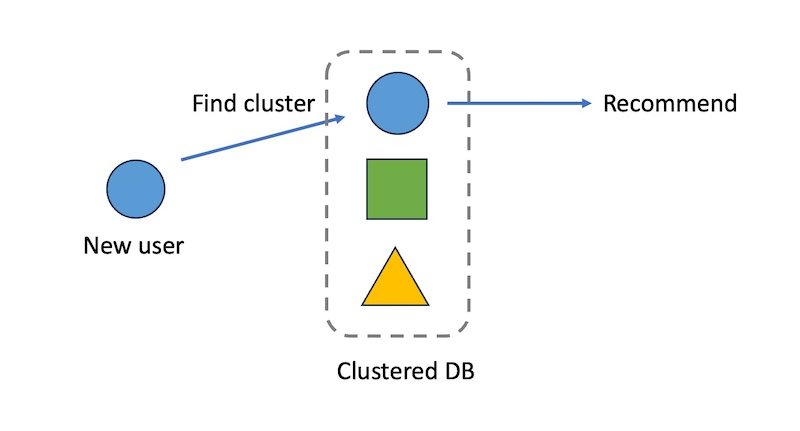

Here, we tried 1) user based clustering and 2) book based clustering. In user based clustering we uses features that distinguish each users such as their age, location to identify clusters in the database. We use within cluster sum of squares to determine the optimal number of clusters. When a new user enteres their information, the model finds 5 most closest people from the database and recommend top 5 books these people ranked highly. This turned out quite effective.

** 5 closest people from the same cluster

We also did a book based clustering that seperates books into clusters and recommends a book similar to the new user's choice of book. Categorical features of the book such as publisher, author were one-hot encoded. This took more than 30 minutes to run on sklearn. So we moved to pyspark which ran under 3 minutes. Yet, as we do not have much information pertaining to the book, it is ****

Overall performance of Kmeans clustering was effective and fast. Lack of data, genre. needs numeric,

## 3.4.1 Clustering users

In [146]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

Our first approach is to cluster each users based on their demographic and their preferred book.

For the purpose of clustering, we combine the main Kaggle dataset with the smaller dataset from the Library of Congress, which offers additional features such as page length that can aid in distinguishing clusters. Since the Library of Congress dataset is significantly smaller, we will include all implicit ratings to preserve as much of the dataset size as possible. Regarding the numeric value of implicit ratings, we will assign the mean rating of the book instead of zero.

In [147]:
# Join Kaggle data with the LoC data
cluster_df = df_cleaned.merge(loc_clean, left_on='ISBN', right_on='isbn')
cluster_df = cluster_df[['User-ID','Age','State','ISBN','title','Book-Rating','Book-Author','Year-Of-Publication','Publisher','pages']]
# Set datatypes, clean nulls
cluster_df['Year-Of-Publication'] = pd.to_numeric(cluster_df['Year-Of-Publication'], errors='coerce')
cluster_df.dropna(inplace=True)
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122203 entries, 0 to 129441
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              122203 non-null  int64  
 1   Age                  122203 non-null  float64
 2   State                122203 non-null  object 
 3   ISBN                 122203 non-null  object 
 4   title                122203 non-null  object 
 5   Book-Rating          122203 non-null  int64  
 6   Book-Author          122203 non-null  object 
 7   Year-Of-Publication  122203 non-null  int64  
 8   Publisher            122203 non-null  object 
 9   pages                122203 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 10.3+ MB


In [148]:
# In case of no rating (0), want to fill it with average rating
# Calculate the average rating for each book, excluding zeros
mean_rating = cluster_df[cluster_df['Book-Rating'] != 0].groupby('ISBN')['Book-Rating'].mean()

# Function to replace zero rating with average rating
def replace_zeros(row):
  if row['Book-Rating'] == 0:
    try:
      return mean_rating[row['ISBN']]
  # if no average rating exist, return 0
    except KeyError:
      return 0
  else:
    return row['Book-Rating']

# Apply the function to replace zeros
cluster_df['Book-Rating'] = cluster_df.apply(replace_zeros, axis=1)

# drop 0 values in ratings b/c if any still remains it means there was no average rating available
cluster_df = cluster_df.query("`Book-Rating` != 0")

In [149]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# cluster_df.to_csv('cluster_df.csv',index = True)

After merging the dataframes and rearranging the implicit ratings, this is the Users database we will work with. Each unique userID corresponds to a single row featuring their most commonly residing state, average book rating, average page length of their books, and average year of publication. These attributes serve as the features for our analysis. We selected these features because they serve as natural heuristics reflecting the nature of the reader. They indicate whether a person prefers long or short books, old or new books, and whether they tend to rate them high or low.

In [150]:
columns_to_choose = ['User-ID', 'Age', 'State', 'Book-Rating', 'pages', 'Year-Of-Publication']
users_df = cluster_df[columns_to_choose]

# create database of users
users_df = users_df.groupby('User-ID').agg({
  'Age': 'mean',                      # average age
  'State': lambda x: x.mode()[0],     # mode of state
  'Book-Rating': 'mean',              # average age
  'pages': 'mean',                    # average pages of book they read
  'Year-Of-Publication': 'mean'       # average year of publication year
}).reset_index()
users_df

User-ID   Age         State  Book-Rating       pages  \
0           20  19.0  pennsylvania     9.000000  259.000000   
1           99  42.0      colorado     9.000000  282.500000   
2          109  20.0       indiana     5.000000  189.000000   
3          139  35.0      maryland    10.000000  375.000000   
4          199  38.0         texas     8.111111  321.000000   
...        ...   ...           ...          ...         ...   
13951   278819  32.0         texas     6.647059  163.000000   
13952   278824  41.0    new jersey     6.000000  362.000000   
13953   278832  62.0       florida    10.000000  358.500000   
13954   278843  28.0    california     7.571465  291.818182   
13955   278851  33.0         texas     6.333333  438.000000   

       Year-Of-Publication  
0              1998.000000  
1              2000.500000  
2              1995.000000  
3              2004.000000  
4              2003.000000  
...                    ...  
13951          2003.000000  
13952          2001.000000  
13953          1996.000000  
13954          1997.636364  
13955          1992.000000  

[13956 rows x 6 columns]

In [151]:
# Export dataframe to CSV for the website
# commented out to avoid repeated export
# users_df.to_csv('users_df.csv', index=False)

To apply K-means clustering to our dataset, some preprocessing is neccessary. The algorithm works by calculating the Euclidean distance between data points to assign them to clusters. If the features in the dataset have different scales, features with larger scales will disproportionately influence the distance calculations

Scaling normalizes the features to a common scale. We will use StandardScaler that normalizes numeric features to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the distance calculations. This makes the resulting clusters more meaningful and interpretable.

Also, K-means algorithm requires numerical input and does not natively handle categorical variables. So we use one-hot encoding to converts categorical variables into a binary vector representation where each category is represented by a unique vector.

For execution, we use pipeline feature in the scikit-learn library. The pipeline allows us to easily review the modeling process and to call it later like a function.

In [152]:
# Define preprocessing for numeric columns (scaling)
numeric_features = ['Age', 'Book-Rating', 'pages', 'Year-Of-Publication']
numeric_transformer = StandardScaler()

# Define preprocessing for categorical features (one-hot encoding)
categorical_features = ['State']
categorical_transformer = OneHotEncoder()

# Create preprocessing steps
preprocessor = ColumnTransformer(
  transformers=[
      ('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features)
  ])

# Create a preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply transformations
X_processed = pipeline.fit_transform(users_df).toarray() # covert sparse matrix to dense array

To determine the optimal number of clusters, we use elbow method and look at the plot of Within-Cluster Sum of Squares (WCSS) againt the number of clusters. WCSS represents the total sum of the squared distance between each point in a cluster and the centroid of that cluster.

Upon reviewing the plot, we decide that k=20 is where we see sufficient diminishing return in terms of compactness gained by increasing the number of clusters. However, we note that this is eyeballing and WCSS can be easily influenced by outlieres. Other metrics like silhouette score might be useful in conjunction in the future for more comprehensive analysis.

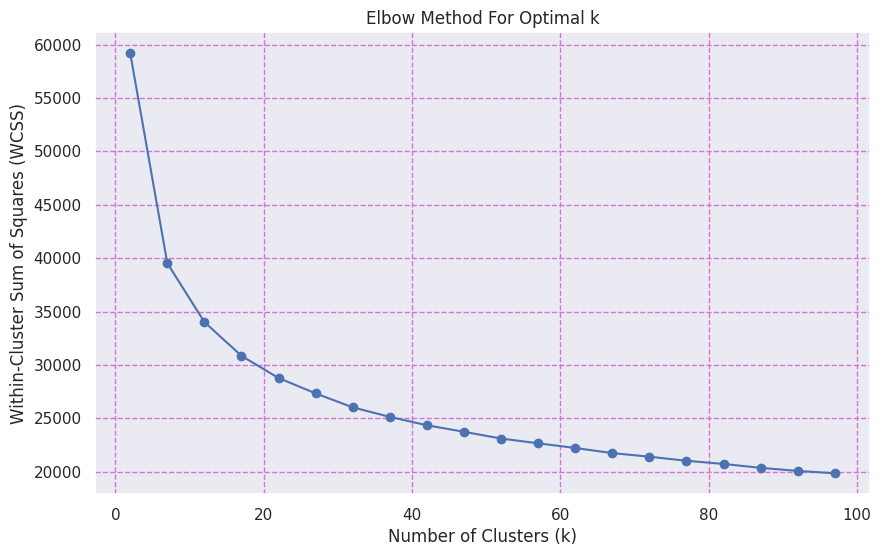

CPU times: user 4min 19s, sys: 24.4 s, total: 4min 43s
Wall time: 2min 52s


In [153]:
%%time
# KMeans clustering and inertia plot
wcss = []
K = range(2, 100, 5)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

# Plotting the inertia
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

Build the K-means clustering model with K=20. We will use this for our recommendation.

In [154]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans.fit(X_processed)
labels = kmeans.labels_

clustered_users_df = users_df.copy()
clustered_users_df['cluster'] = labels

# Extracting the centroids
centroids = kmeans.cluster_centers_

# Getting feature names after transformation
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())

# Creating a DataFrame for the centroids
centroids_df = pd.DataFrame(centroids, columns=feature_names)

We plotted t-SNE (t-distributed Stochastic Neighbor Embedding) expecting it to clearly visualize distinct clusters. However, despite numerous adjustments to the parameters, we were unable to achieve a satisfactory visualization. We learned that t-SNE is highly sensitive to hyperparameters, particularly perplexity and learning rate. To achieve clearer clustering, it may be necessary to further experiment with its parameters, preprocess the data to reduce noise, or consider using alternative or complementary dimensionality reduction techniques.

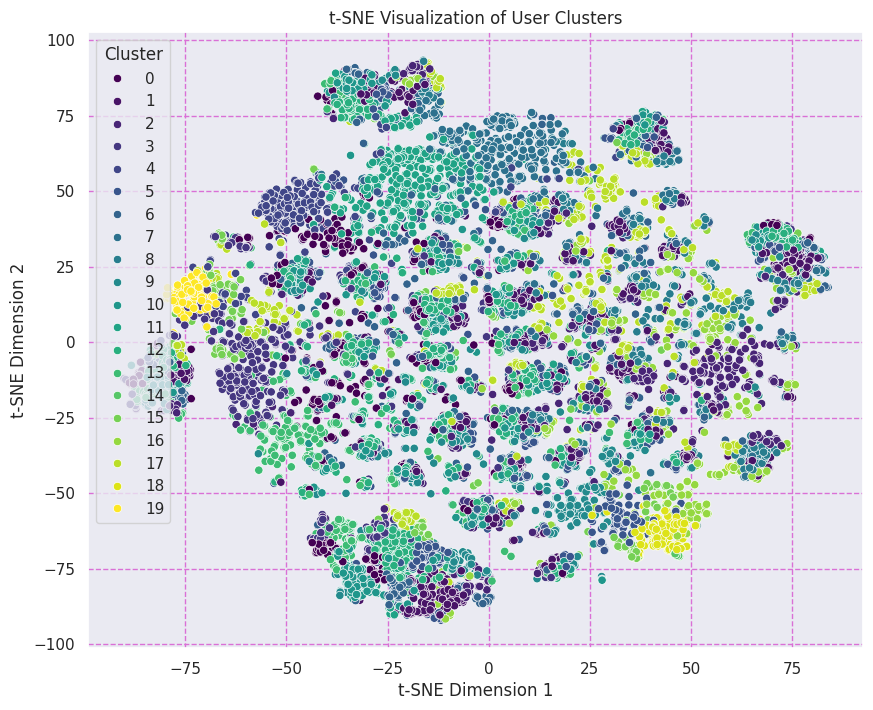

CPU times: user 5min 53s, sys: 631 ms, total: 5min 53s
Wall time: 3min 38s


In [155]:
%%time
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity = 50, learning_rate = 600)
X_tsne = tsne.fit_transform(X_processed)

# Creating a DataFrame for Seaborn Plot
tsne_df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'Cluster': labels
})

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue='Cluster', palette='viridis', data=tsne_df, legend='full', marker='o')
plt.title('t-SNE Visualization of User Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

This is a summary of our 20 cluster of users. Note that California appears to be the most prevalent state, but this is primarily because our dataset has the highest number of users from that state. The other numeric values represent the averages for the cluster.

In [156]:
# Statistical summary of clusters
cluster_summary = clustered_users_df.groupby('cluster').agg({
  'Age': 'mean',                      # average age
  'State': lambda x: x.mode()[0],     # mode of state
  'Book-Rating': 'mean',              # average age
  'pages': 'mean',                    # average pages of book they read
  'Year-Of-Publication': 'mean'       # average year of publication year
}).reset_index()
cluster_summary

cluster        Age       State  Book-Rating        pages  \
0         0  21.452312  california     7.182813   188.072995   
1         1  42.774714  california     7.645367   349.737718   
2         2  49.575604  california     9.399507   276.993937   
3         3  29.623377  california     8.886364   198.010103   
4         4  34.654040  california     5.386499   272.887856   
5         5  30.338757  california     7.431827   475.021348   
6         6  42.189718  california     7.370515   213.043658   
7         7  52.153974  california     5.242644   342.167733   
8         8  62.894374  california     7.661689   320.314966   
9         9  29.393690  california     9.295701   399.259465   
10       10  25.533430  california     7.640917   318.424010   
11       11  28.692635  california     4.837658   297.637526   
12       12  32.153113  california     7.734321   324.811034   
13       13  23.205165  california     9.177451   216.760345   
14       14  28.333333     alabama     9.396825  1714.722222   
15       15  38.003802  california     8.302283   474.214857   
16       16  54.908772  california     8.301983   476.137129   
17       17  55.308458  california     7.598729   297.423813   
18       18  35.971591  california     7.950247   784.082359   
19       19  36.754098  california     7.874564   240.137204   

    Year-Of-Publication  
0           1995.401434  
1           2000.376543  
2           1999.631876  
3           1989.374451  
4           1988.659795  
5           1997.232425  
6           1998.939056  
7           1999.262921  
8           1999.765464  
9           1999.784638  
10          2000.207350  
11          1999.025326  
12          1994.560705  
13          1999.009573  
14          1992.555556  
15          1987.076667  
16          1999.273900  
17          1992.123334  
18          1997.234267  
19          1975.623139

In [157]:
# Code For exporting pre-training model , to be used for website
## Reserved ##
# cluster_summary.to_csv('cluster_summary.csv', index=False)

Let's run our model and evaluate the results by introducing a new user. Suppose we ask the new user for her age and State, as well as her favorite book from our database. We then extract the book's rating, page length, and publication year. We use these features to predict which cluster she belongs to.

In [158]:
# New user data
new_user_data = {
    'Age': [28],  # Example age
    'State': ['colorado'],  # Example locationa
    'Book-Rating':[5],
    'pages': [300],
    'Year-Of-Publication': [2000]
}
new_user_df = pd.DataFrame(new_user_data)

In [159]:
# Preprocess the new user's data and predict the cluster
preprocessed_new_user = pipeline.named_steps['preprocessor'].transform(new_user_df).toarray() # covert sparse matrix to dense array

predicted_cluster = kmeans.predict(preprocessed_new_user)
print("The new user belongs to cluster:", predicted_cluster[0])

The new user belongs to cluster: 11


Now that we have identified the cluster to which the new user belongs, we can filter our existing users based on this predicted cluster. Then, we find the five users who are closest in distance to the new user.

In the case of our demo user, we can see that the clustering result looks good. Her five closest users all exhibit similar characteristics in terms of location and the average characteristics of the books they read.

In [160]:
# Filter existing users by the predicted cluster of the new user
filtered_users = clustered_users_df[clustered_users_df['cluster'] == predicted_cluster[0]]
filtered_users_X = X_processed[filtered_users.index]

# Compute distances from the new user to the filtered existing users
distances = np.linalg.norm(filtered_users_X - preprocessed_new_user, axis=1)

# Get the indices of the 5 closest users in the filtered set
closest_indices = np.argsort(distances)[:5]

# Print the indices and distances of the closest users
print("Indices of closest users:", filtered_users.index[closest_indices])
print("Distances of closest users:", distances[closest_indices])

# Retrieve the rows corresponding to these indices
selected_rows = filtered_users.iloc[closest_indices]
selected_rows

Indices of closest users: Index([4406, 1132, 13634, 5100, 6110], dtype='int64')
Distances of closest users: [0.60230046 1.04249407 1.09632678 1.17957897 1.28878025]


User-ID   Age     State  Book-Rating       pages  Year-Of-Publication  \
4406     88946  33.0  colorado     4.333333  302.666667          2000.333333   
1132     24525  28.0  colorado     5.645000  304.500000          1995.250000   
13634   271466  32.0  colorado     5.000000  400.000000          1996.666667   
5100    102933  35.0  colorado     6.000000  237.000000          1997.000000   
6110    122807  27.0  colorado     6.000000  386.000000          1996.000000   

       cluster  
4406        11  
1132        11  
13634       11  
5100        11  
6110        11

Finally, we retrieve the books highly rated by those five similar users and recommend them to our new user.

In [161]:
similar_user_ids = selected_rows['User-ID']

# Filter the DataFrame for these users
filtered_df = cluster_df[cluster_df['User-ID'].isin(similar_user_ids)]

# Sort the filtered DataFrame by 'Rating' in descending order
sorted_df = filtered_df.sort_values(by='Book-Rating', ascending=False)

# Remove duplicates based on isbn to ensure uniqueness, keep the highest rating
unique_sorted_df = sorted_df.drop_duplicates(subset='ISBN', keep='first')

# Get the top 5 highest-rated books
top_books = unique_sorted_df.head(5)
top_books

User-ID   Age     State        ISBN  \
85335    271466  32.0  colorado  0880385359   
10576     24525  28.0  colorado  0767902521   
35242    122807  27.0  colorado  0449911411   
60847     24525  28.0  colorado  0060182172   
104256   102933  35.0  colorado  0962461369   

                                                    title  Book-Rating  \
85335                                   The crystal shard         9.00   
10576   A walk in the woods : rediscovering America on...         8.58   
35242                  And I don't want to live this life         6.00   
60847                                   Atticus : a novel         6.00   
104256  Sex and the single beer can : probing the medi...         6.00   

             Book-Author  Year-Of-Publication             Publisher  pages  
85335    R. A. Salvatore                 1988  Wizards of the Coast  336.0  
10576        Bill Bryson                 1999        Broadway Books  276.0  
35242    Deborah Spungen                 1996      Ballantine Books  386.0  
60847         Ron Hansen                 1996         Harpercollins  247.0  
104256  Walter M. Brasch                 1997    Mayfly Productions  237.0

## 3.4.2 Clustering books

Clustering based on users turned out promising. However, we only have limited features of users. Therefore, we want to attempt clustering books in our dataset, with the anticipation that we can recommend a similar book based on the new user's choice of book.

For the features, we choose all the information we have about the book, including the author, publisher, and average age of their readers. We omit the state to avoid complicating the model further, and also because we know that California is the most prevalent state of the readers.

We also remove duplicates based on titles and author. Books with the same title, author but different ISBNs are often the same books in different printing editions, so we remove them here to clarify the book based clustering performance.

In [162]:
# filter only unique titles and authors
unique_title_df = cluster_df.drop_duplicates(subset=['title', 'Book-Author'], keep='first')

# rearrange column orders
new_order = ['ISBN', 'Age', 'Book-Author', 'Book-Rating', 'Publisher', 'pages', 'Year-Of-Publication']
books_df = unique_title_df[new_order]

# remove hyphen and rename columns for ease of use
books_df.rename(columns={'Book-Author': 'author', 'Book-Rating':'rating', \
                         'Age':'age', 'Publisher':'publisher',\
                         'Year-Of-Publication':'year'}, inplace=True)
# convert strings to lower case
books_df['author'] = books_df['author'].str.lower()
books_df['publisher'] = books_df['publisher'].str.lower()
books_df

ISBN   age             author     rating  \
4       0425099148  27.0    agatha christie  10.000000   
9       0891075275  23.0   frank e. peretti   9.100000   
34      0891076182  30.0   frank e. peretti   7.500000   
49      0425163091  19.0  stephan jaramillo   9.000000   
53      0375406328  26.0       mark salzman   7.166667   
...            ...   ...                ...        ...   
129434  1567310028  57.0        helmstetter   7.000000   
129435  0060530103  54.0      doris lessing   7.000000   
129436  0446608831  54.0      texas monthly   8.000000   
129437  0670528951  63.0    barbara leaming   8.000000   
129440  067161746X  33.0      p.j. o'rourke   7.000000   

                       publisher  pages  year  
4       berkley publishing group  230.0  1997  
9                 crossway books  441.0  1989  
34                crossway books  416.0  1992  
49      berkley publishing group  259.0  1998  
53               alfred a. knopf  181.0  2000  
...                          ...    ...   ...  
129434                 mjf books  228.0  1997  
129435             harpercollins  311.0  2004  
129436              warner books  515.0  2000  
129437               penguin usa  562.0  1985  
129440              pocket books  126.0  1987  

[20523 rows x 7 columns]

In [163]:
unique_title_df = cluster_df.drop_duplicates(subset=['title', 'Book-Author'], keep='first')

columns_to_choose = ['ISBN', 'Age', 'Book-Author', 'Book-Rating', 'Publisher', 'pages', 'Year-Of-Publication']
books_df = unique_title_df[columns_to_choose]

# create database of users
books_df = books_df.groupby('ISBN').agg({
  'Age': 'mean',                        # average age
  'Book-Author': lambda x: x.mode()[0], # mode of author
  'Book-Rating': 'mean',                # average rating
  'Publisher': lambda x: x.mode()[0],   # mode of publisher
  'pages': 'mean',                      # average page length
  'Year-Of-Publication': 'mean'         # average publication year
}).reset_index()

# remove hyphen and rename columns for ease of use
books_df.rename(columns={'Book-Author': 'author', 'Book-Rating':'rating', \
                         'Age':'age', 'Publisher':'publisher',\
                         'Year-Of-Publication':'year'}, inplace=True)
# convert strings to lower case
books_df['author'] = books_df['author'].str.lower()
books_df['publisher'] = books_df['publisher'].str.lower()
books_df

ISBN   age                   author  rating  \
0      0002179695  28.0              rick smolan     9.0   
1      000225056X  29.0  publishers staf collins    10.0   
2      0002250985  26.0            jesse z. cool     6.0   
3      0002550555  33.0             bill messing     7.0   
4      0002550563  22.0              j.c. suares     4.0   
...           ...   ...                      ...     ...   
20518  9129590647  26.0           cristina bjork     8.0   
20519  9211003997  48.0       john travers moore     9.0   
20520  9682314038  26.0                   ortega     9.0   
20521  9724111229  25.0             joã£o aguiar     8.0   
20522  9728128045  43.0          james h. marrow    10.0   

                                          publisher  pages    year  
0                      harpercollins juvenile books  236.0  1991.0  
1                                     harpercollins   96.0  1995.0  
2                                     harpercollins  118.0  1997.0  
3                                collins publishers  223.0  1992.0  
4                                     harpercollins   78.0  1992.0  
...                                             ...    ...     ...  
20518                                   r & s books   59.0  1988.0  
20519                             renouf pub co ltd   46.0  1988.0  
20520  siglo veintiuno editores siglo xxi editores,  505.0  1994.0  
20521                                           asa  234.0  1992.0  
20522                         univ of washington pr  186.0  1997.0  

[20523 rows x 7 columns]

This is the dataframe of unique books with its features and the average age of the readers.

We apply the same clustering process as we did previously, using StandardScaler and One-Hot encoding preprocessing in a scikit-learn pipeline.

In [164]:
# Define preprocessing for numeric columns (scaling)
numeric_features = ['age', 'rating', 'pages', 'year']
numeric_transformer = StandardScaler()

# Define preprocessing for categorical features (one-hot encoding)
categorical_features = ['author', 'publisher']
categorical_transformer = OneHotEncoder()

# Create preprocessing steps
preprocessor = ColumnTransformer(
  transformers=[
      ('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features)
  ])

# Create a preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply transformations
X_processed = pipeline.fit_transform(books_df).toarray() # covert sparse matrix to dense array

However, the K-means clustering of books takes way too long to fit in scikit-learn. One test ran over 8 minutes. The model one-hot encodes authors and publishers during preprocessing, which likely contributes to the lengthened running time.

In [165]:
%%time
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans.fit(X_processed)

CPU times: user 39min 50s, sys: 23.3 s, total: 40min 13s
Wall time: 25min 16s


KMeans(n_clusters=20, n_init=10, random_state=42)

So we do this clustering in PySpark. PySpark leverages distributed computing power and parallel processing. We anticipate that the book clustering model will run much faster in PySpark.

In the following we set up the PySpark environment and rewrite our model using Spark code.

In [166]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bcc167405d41796dd6e80b1e9d40cd8e418e4557072f2a7b00ecd8a1b92e95aa
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [167]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf, col, lit, rank
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import SparseVector, DenseVector

In [168]:
# Initialize Spark Session
spark = SparkSession.builder.appName("K-means Clustering").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [169]:
# convert pandas dataframe to spark dataframe
books_sdf = spark.createDataFrame(books_df)
books_sdf.show()

+----------+----+--------------------+------+--------------------+-----+------+
|      ISBN| age|              author|rating|           publisher|pages|  year|
+----------+----+--------------------+------+--------------------+-----+------+
|0002179695|28.0|         rick smolan|   9.0|harpercollins juv...|236.0|1991.0|
|000225056X|29.0|publishers staf c...|  10.0|       harpercollins| 96.0|1995.0|
|0002250985|26.0|       jesse z. cool|   6.0|       harpercollins|118.0|1997.0|
|0002550555|33.0|        bill messing|   7.0|  collins publishers|223.0|1992.0|
|0002550563|22.0|         j.c. suares|   4.0|       harpercollins| 78.0|1992.0|
|0002551675|42.0|francis ford coppola|   8.0|       harpercollins| 96.0|1992.0|
|0002552175|24.0|        j. c. suares|  10.0|       harpercollins| 79.0|1993.0|
|0004709950|33.0| christopher f. foss|   9.0|      harperresource|510.0|1996.0|
|000599134X|53.0|      jacques musset|  10.0|       harpercollins|528.0|1989.0|
|0006480985|23.0|     cordelia strube|  

In [170]:
# Define preprocessing for numeric columns (scaling)
numeric_features = ['age', 'rating', 'pages', 'year']
numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features")
numeric_scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

# Define preprocessing for categorical features (one-hot encoding)
categorical_features = ['author', 'publisher']
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_indexed") for column in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{column}_indexed", outputCol=f"{column}_encoded") for column in categorical_features]

# Assemble all features into a single vector
feature_cols = [f"{column}_encoded" for column in categorical_features] + ["scaled_numeric_features"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

To determine the optimal number of clusters, we use the elbow method and examine the plot of Within-Cluster Sum of Squares (WCSS) against the number of clusters as before.

We run it up to K=50 clusters, stepping over every 5 clusters to reduce the time. In the end, we observe that the model runs much faster than it would have using scikit-learn.

In [171]:
# takes about 6 minutse
%%time
costs = []
for k in range(2, 51, 5):
  kmeans = KMeans(featuresCol='features', k=k)
  stages = indexers + encoders + [numeric_assembler, numeric_scaler, assembler, kmeans]
  pipeline = Pipeline(stages=stages)
  # Fit the model
  model = pipeline.fit(books_sdf)

  # Extract kmeans
  kmeans_model = model.stages[-1]

  # Get the training cost (WCSS)
  wcss = kmeans_model.summary.trainingCost
  costs.append(wcss)

CPU times: user 2.28 s, sys: 302 ms, total: 2.58 s
Wall time: 4min 27s


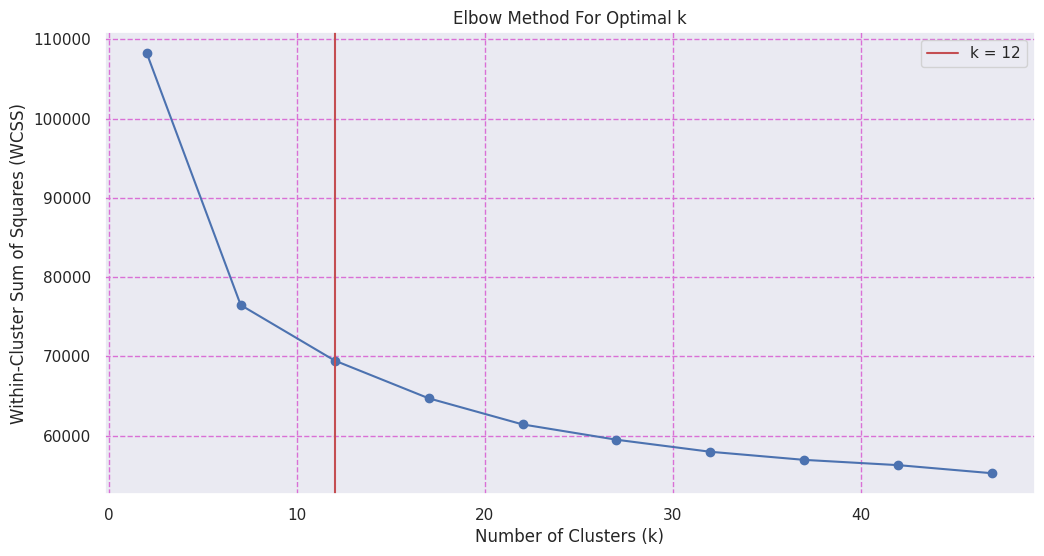

In [172]:
plt.plot(range(2, 51, 5), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=12, color='r', linestyle='-', label='k = 12')
plt.legend()
plt.show()

We choose k=12 to be a suitable number of clusters for our purpose as we observe a significant reduction in error (WCSS).

Next, we fit a new model with 12 clusters, introduce a new book, and evaluate the model's performance in suggesting similar books.

In [173]:
%%time
kmeans = KMeans(featuresCol='features', k=12)
stages = indexers + encoders + [numeric_assembler, numeric_scaler, assembler, kmeans]
pipeline = Pipeline(stages=stages)

# Fit the model
model = pipeline.fit(books_sdf)
transformed_sdf = model.transform(books_sdf)

# Join the original dataframe with the predictions dataframe to add the cluster labels
book_sdf_clustered = books_sdf.join(transformed_sdf.select("ISBN", "prediction"), on="ISBN", how="left")

CPU times: user 217 ms, sys: 31.2 ms, total: 248 ms
Wall time: 19.6 s


In [174]:
# convert the cluster labeld dataframe to pandas
books_df_clustered = book_sdf_clustered.toPandas()
books_df_clustered.rename(columns={'prediction': 'cluster'}, inplace=True)

# Statistical summary of clusters
cluster_summary = books_df_clustered.groupby('cluster').agg({
  'ISBN': lambda x: x.mode()[0],
  'age': 'mean',                      # average age
  'author': lambda x: x.mode()[0],    # mode of author
  'rating': 'mean',                   # average ratinge
  'pages': 'mean',                    # average page length
  'publisher': lambda x: x.mode()[0], # mode of publisher
  'year': 'mean'                      # average publication year
}).reset_index()
cluster_summary

cluster        ISBN        age                author    rating  \
0         0  0002250985  28.753191           r. l. stine  6.364746   
1         1  0020225601  38.098958          stephen king  8.253175   
2         2  000225056X  27.309514           r. l. stine  8.999690   
3         3  0020228732  66.174405          nora roberts  7.120665   
4         4  0002179695  34.416520       mercedes lackey  8.707575   
5         5  0002550555  28.965930       francine pascal  5.753648   
6         6  0020009607  43.537015  laura ingalls wilder  8.726609   
7         7  0004709950  31.163813         jack canfield  8.504645   
8         8  0002551675  46.658379           penny frank  8.813715   
9         9  0028610407  50.020840        bertrice small  8.818413   
10       10  0020188706  51.495991        marion chesney  5.995014   
11       11  0020295456  40.942575           r. l. stine  4.635936   

         pages                 publisher         year  
0   255.651064  berkley publishing group  1998.868511  
1   871.159722   oxford university press  1993.631944  
2   187.654955                scholastic  1998.108172  
3   302.362401          simon & schuster  1997.842582  
4   340.682484             harpercollins  1989.658465  
5   205.454880             harpercollins  1986.906077  
6   238.025852             penguin books  1977.359577  
7   391.817510                      avon  1999.778599  
8   170.107907             harpercollins  1994.204376  
9   325.805895     st. martin's minotaur  2001.439416  
10  282.893471          simon & schuster  1986.910653  
11  287.593387             harpercollins  1998.370070

In [175]:
# Create a row for the new book - suppose, it is Harry Potter and the Sorcerer's Stone
new_book = [Row(age=28, rating=10, pages=309, author="j. k. rowling", publisher="scholastic", year=1998)]

# Create a spark dataframe from the row
new_book_sdf = spark.createDataFrame(new_book)

# Use the same pipeline to transform the data
new_book_transformed = model.transform(new_book_sdf)

predicted_cluster = new_book_transformed.select("prediction").collect()[0]["prediction"]
print(f"The new book is predicted to belong to cluster {predicted_cluster}")

The new book is predicted to belong to cluster 2


Now, we want to find the 5 closest books within the same cluster. The process mirrors what we did previously with the user clusters. However, to calculate the distance, we need to utilize a user-defined function (UDF) in PySpark. We use this because PySpark lacks native support for the same array manipulations as NumPy on DataFrames.

In [176]:
# UDF to calculate Euclidean distance
def euclidean_distance(v1, v2):
  return float(np.linalg.norm(np.array(v1) - np.array(v2)))

# Compute distances from the new user to all existing users
distance_udf = udf(euclidean_distance, FloatType())

In [177]:
# Extract the feature vector for the new data
new_book_sparse_vector = new_book_transformed.select("features").collect()[0]["features"]
new_book_vector = new_book_sparse_vector.toArray()

In [178]:
%%time
# filter for the same cluster
same_cluster_sdf = transformed_sdf.filter(col("prediction") == predicted_cluster)

# calculate the distance and add as a new column of distance
same_cluster_sdf = same_cluster_sdf.withColumn("distance", distance_udf(col("features"), lit(new_book_vector)))

# Using window function to select top 5 closest books
windowSpec = Window.orderBy("distance")
closest_books_sdf = same_cluster_sdf .withColumn("rank", rank().over(windowSpec)).filter(col("rank") <= 5)

# save the resulting isbn of similar books to python list
isbn_rows = closest_books_sdf.select('ISBN').collect()
isbn_list = [row['ISBN'] for row in isbn_rows]

# close spark session
spark.stop()

CPU times: user 2.59 s, sys: 549 ms, total: 3.14 s
Wall time: 5min 11s


In [179]:
top_books = df_books[df_books['ISBN'].isin(isbn_list)]
top_books

ISBN                                         Book-Title  \
2809    0590353403     Harry Potter and the Sorcerer's Stone (Book 1)   
60766   0590762591                     The Attack (Animorphs, No. 26)   
67243   0590897993                                              Bat 6   
103584  0439295955                                         Martyn Pig   
212392  0590054880  National Audubon Society First Field Guide Wea...   

                 Book-Author Year-Of-Publication   Publisher  \
2809           J. K. Rowling                1998  Scholastic   
60766        K. A. Applegate                1999  Scholastic   
67243   Virginia Euwer Wolff                1998  Scholastic   
103584          Kevin Brooks                2002  Scholastic   
212392      Jonathan D. Kahl                1998  Scholastic   

                                              Image-URL-S  \
2809    http://images.amazon.com/images/P/0590353403.0...   
60766   http://images.amazon.com/images/P/0590762591.0...   
67243   http://images.amazon.com/images/P/0590897993.0...   
103584  http://images.amazon.com/images/P/0439295955.0...   
212392  http://images.amazon.com/images/P/0590054880.0...   

                                              Image-URL-M  \
2809    http://images.amazon.com/images/P/0590353403.0...   
60766   http://images.amazon.com/images/P/0590762591.0...   
67243   http://images.amazon.com/images/P/0590897993.0...   
103584  http://images.amazon.com/images/P/0439295955.0...   
212392  http://images.amazon.com/images/P/0590054880.0...   

                                              Image-URL-L  
2809    http://images.amazon.com/images/P/0590353403.0...  
60766   http://images.amazon.com/images/P/0590762591.0...  
67243   http://images.amazon.com/images/P/0590897993.0...  
103584  http://images.amazon.com/images/P/0439295955.0...  
212392  http://images.amazon.com/images/P/0590054880.0...


The clustering results for our book recommender model demonstrate its effectiveness. For a demo user we created who chose a Harry Potter book, our model successfully recommended similar young adult fiction from the same publisher, all published around the same time.  The performance was impressively good, especially considering that we lacked genre information for the books. However, the overall process was still time-consuming. The delay was not due to the fitting of the k-means algorithm but primarily from computing distances and ranking them. In a practical application, speed would be as crucial as accuracy.

# 4.0 Text-Based Prediction Using Doc2Vec

Here, we explore an approach where a user can submit a summary of the type of book they want, and the model will try to provide recommendations based on that information.  The model leverages a new [dataset](https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset/data), containing rich summaries of 16,559 books.  It vectorizes the summaries, and then can take in a user-supplied summary and provide personalized recommendations.**f**

In [181]:
import csv
# Import the Summarized Book Dataset
data = []
with open('booksummaries.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        data.append(row)

# convert data to pandas dataframe
summarized_books = pd.DataFrame.from_records(data, columns=['book_id', 'freebase_id', 'title', 'author', 'publication_date', 'genre', 'summary'])
print(summarized_books.shape)
summarized_books.head()

(450, 7)


book_id freebase_id                                      title  \
0     620     /m/0hhy                                Animal Farm   
1     843     /m/0k36                         A Clockwork Orange   
2     986     /m/0ldx                                 The Plague   
3    1756     /m/0sww  An Enquiry Concerning Human Understanding   
4    2080     /m/0wkt                       A Fire Upon the Deep   

            author publication_date  \
0    George Orwell       1945-08-17   
1  Anthony Burgess             1962   
2     Albert Camus             1947   
3       David Hume                    
4     Vernor Vinge                    

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                      
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

In [182]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class SummaryBookRecommender:
    def __init__(self, df):
        self.df = df
        self.model = None
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        # Tokenize the text into words
        tokens = word_tokenize(text.lower())

        # Remove stopwords and lemmatize tokens
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]

        return tokens

    def preprocess_data(self):
        # Limit summaries to the first 100 words
        self.df['summary'] = self.df['summary'].apply(lambda x: ' '.join(x.split()[:100]))

        # Tokenize and preprocess summaries for Doc2Vec
        self.df['summary_tokens'] = self.df['summary'].apply(self.preprocess_text)

        # Create tagged documents for Doc2Vec
        tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(self.df['summary_tokens'])]

        # Train Doc2Vec model
        self.model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=1, workers=4)

        # Generate Doc2Vec embeddings for book summaries
        self.df['embedding'] = self.df['summary_tokens'].apply(lambda x: self.model.infer_vector(x))

    def recommend_books(self, user_input, top_n=5):
        # Tokenize and preprocess user input
        user_input_tokens = self.preprocess_text(user_input)

        # Generate Doc2Vec embedding for user input
        user_input_embedding = self.model.infer_vector(user_input_tokens)

        # Calculate cosine similarity between user input and book summaries
        self.df['similarity'] = self.df['embedding'].apply(lambda x: cosine_similarity([user_input_embedding], [x])[0][0])

        # Get top N similar books
        top_books = self.df.nlargest(top_n, 'similarity')

        return top_books[['title', 'similarity', 'summary']]





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [183]:
recommender = SummaryBookRecommender(summarized_books)
recommender.preprocess_data()

In [184]:
# See how this works with some examples:
examples = ['thrilling mystery novel set in a small town, where a detective must uncover the truth behind a series of puzzling disappearances.',
            "heartwarming romance story about two childhood friends who reconnect after years apart and discover their feelings for each other have grown stronger.",
            "fast-paced action adventure book featuring a treasure hunt across exotic locations, with the main characters racing against time to solve ancient riddles.",
            'thought-provoking science fiction novel that explores the consequences of advanced artificial intelligence and its impact on society',
            'gripping psychological thriller that delves into the mind of a unreliable narrator, keeping readers guessing until the shocking climax'
            ]

for example in examples:
  print('Prompt:\n', example)
  print('Recommendations:')
  print(recommender.recommend_books(example))

Prompt:
 thrilling mystery novel set in a small town, where a detective must uncover the truth behind a series of puzzling disappearances.
Recommendations:
                    title  similarity  \
274  Love's Labour's Lost    0.973499   
212    The Caves of Steel    0.973199   
232  The Way of All Flesh    0.972831   
65    Pride and Prejudice    0.972764   
421    The Vampire Lestat    0.972754   

                                               summary  
274  The play opens with the King of Navarre and th...  
212  The book's central crime is a murder, which ta...  
232  The story is narrated by Overton, godfather to...  
65   The narrative opens with Mr Bingley, a wealthy...  
421  Set in the late 18th century to the late 1980s...  
Prompt:
 heartwarming romance story about two childhood friends who reconnect after years apart and discover their feelings for each other have grown stronger.
Recommendations:
                          title  similarity  \
370                  The Jungle

In [185]:
# User input and book recommendation
user_input = input("Enter a description of the book you want to read: ")
recommended_books = recommender.recommend_books(user_input)
print("Recommended Books:")
print(recommended_books)

Enter a description of the book you want to read: magiacal adventrue of boy and girl in nature
Recommended Books:
                    title  similarity  \
27            Don Quixote    0.978314   
269  Love and Mr Lewisham    0.978294   
274  Love's Labour's Lost    0.978150   
395                Damage    0.978109   
229    A Farewell to Arms    0.978099   

                                               summary  
27   The First Sally Alonso Quijano, the protagonis...  
269  At the beginning of the novel, Mr. Lewisham is...  
274  The play opens with the King of Navarre and th...  
395  The first person narrator of the novel is an u...  
229  The novel is divided into five books. In the f...  


# Conclusion

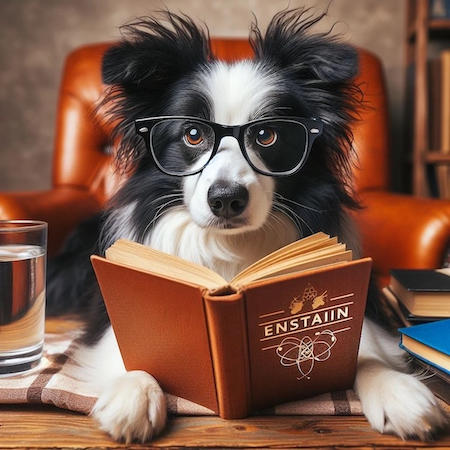

### Initial plan

Initially, our intention was to to develop a robust methodology for predicting which books a user will like given their previous ratings.  The general strategy was to compute the predicted rating of all the other books in the data set based on the user’s information, then output those with the highest predicted ratings.

### Execution

We iterated through a wide variety of modeling approaches to achieve the most accurate and comprehensive prediction model possible, although we did not ultimately use the strategy of predicting the user's rating of all the books, aside from the Neural Net approach.

- Item-Based Collaborative Filtering: Here we leveraged cosine similarity between a vectorized representation of the rating dataset, we were able to provide extremely high quality recommendations with just this approach, which ended up even being stronger than the Neural Net approach.  We had two separate approaches, one encorporating implicit ratings and excluding them.

- User-Based Collaborative Filtering Using a Feed Foward Neural Network: For the user-based collaborative filtering approach, we decided that instead of just aggregating the item-based recommendations for the books rated by a given user, we would use a Neural Net approach.  We found the neural net to be quite powerful, but ultimately the runtimes were too slow to deploy into our front-end model.

- Clustering: First, we clustered based on each user's demographic and preference. Subsequently, we also clustered based on books. Despite having few features and, notably, the absence of genre information, both models demonstrated impressive results. We applied scaling and one-hot encoding techniques within the pipeline. For the book clustering, we used PySpark to accelerate the model, which significantly reduced the learning time.

- Summary-Based Recommendations:  In this approach, we leveraged the power of Doc2Vec to generate vectorized representations of book summaries. By training a Doc2Vec model on a large dataset of book summaries, we were able to generate high-dimensional vectors that capture the semantic meaning of each summary. We then used cosine similarity to calculate the similarity between a user's input query and each book summary, ranking the results to provide personalized book recommendations. This approach allowed us to capture the nuances of book summaries and provide users with relevant recommendations that take into account the context of the query.

### What we learned along the way
* The Significance of Data

We learned that data is incredibly important but the perfect data is unlikely to come by. Even when data is available, ensuring its quality is a critical step that must not be overlooked.

* The Effort of Data Preparation

A substantial amount of our time was devoted to cleaning, wrangling, and preparing data, such as vectorizing inputs. This process was more time-consuming than anticipated. Sometimes more so than the actual modeling, which often amounted to a few lines of code.

* Balancing Trade-offs

We faced various trade-offs during the project, between training costs and model accuracy, as well as between running time and performance. Navigating these trade-offs was crucial for optimizing our outcomes.

* Evaluating Success

Determining how to measure the results poses its own set of challenges. We must continuously question what constitutes a good recommendation and how to quantitatively assess the effectiveness of our recommendations.

